In [1]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from e6dataflow.datamodel import load_datamodel, get_datamodel
from e6dataflow.tools.fittools import e6_fit
from scipy.optimize import curve_fit
import colorsys


In [2]:
### Load datamodel from .p file
run_name = 'run1'

datamodel = load_datamodel(datamodel_path=Path.cwd(), run_name=run_name)

Loading datamodel from Y:\expdata-e6\analysis\2021\02\14\run1\run1-datamodel.p


In [3]:
### Information about run:
### Note that molasses intensity is less than 5 for the first two frames,
### so better not use mol_freq = 4.5 and 5 for the 1/delta^2 fit!

tweezer_freq_list = [108,110,112,114,116]
num_tweezers = len(tweezer_freq_list)

probe_att_list = [0.1,3,6,9]
pzt_para_list = [5.5,6,6.5,7,7.5,8,8.5,9,9.5,10]

num_points = datamodel.num_points #len(pzt_para_list) * len(probe_att_list)

tweezer_freq_list = [108,110,112,114,116]
num_tweezers = 5 #len(tweezer_freq_list)

mol_freq_list = [4.5,5,5.5,6,6.5,7,7.5,8]
num_frames = len(mol_freq_list) + 2

num_shots = datamodel.num_shots

num_loops = num_shots // num_points

print(num_points,'points')
print(num_frames,'frames')
print(num_tweezers,'tweezers')
print(num_shots,'shots')
print(num_loops,'complete loops')


t_exposure = 500

t_hold_1 = 100
t_hold_2 = 1000
t_hold_3 = 10000
t_frame_1 = t_exposure + t_hold_1
t_frame_2 = t_exposure + t_hold_2
t_frame_3 = t_exposure + t_hold_3

roi_width = 14
roi_height = 12
roi_area = roi_width * roi_width

40 points
10 frames
5 tweezers
8353 shots
208 complete loops


In [4]:
counts_array = np.zeros((num_frames,len(probe_att_list),len(pzt_para_list),len(tweezer_freq_list),num_loops))

for point in range(num_points):
    probe_att_counter = point % len(probe_att_list)
    pzt_para_counter = point // len(probe_att_list)
    for frame_num in range(num_frames):
        for twz_counter in range(num_tweezers):
            counts_array[frame_num,probe_att_counter,pzt_para_counter,twz_counter,:]=\
                datamodel.get_data_by_point(f'frame-{frame_num:02d}_tweezer-{twz_counter:02d}_counts',point,\
                                           shots=range(num_loops*num_points))
            
print(counts_array.shape)

(10, 4, 10, 5, 208)


c:\python37-32\lib\site-packages\ipykernel_launcher.py:102: RuntimeWarning: Mean of empty slice
c:\python37-32\lib\site-packages\numpy\lib\nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


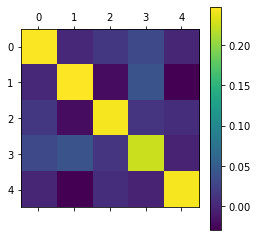

mean_in_theory:2.5, std_in_theory:1.118033988749895
mean:2.0384615384615383, std:1.1512791959304436
[0, 16]
[1, 56]
[2, 68]
[3, 42]
[4, 24]
[5, 2]


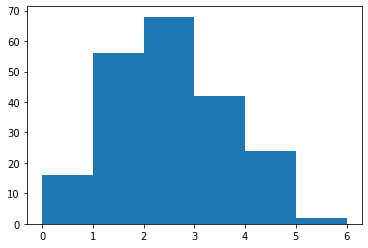

In [5]:
show_plot = False
zeropeakHWFMper = 1.5
# zeropeakHWFMper = 3
num_avg = 20 # number of loops to put in moving average

# Calculate cav_brightness and cav_fidelity for every shot!! 

cav_brightness = np.zeros((len(mol_freq_list),len(probe_att_list),len(pzt_para_list),len(tweezer_freq_list),num_loops))
cav_fidelity = np.zeros((len(mol_freq_list),len(probe_att_list),len(pzt_para_list),len(tweezer_freq_list),num_loops))
cav_brightness_mov_avg = np.zeros((len(mol_freq_list),len(probe_att_list),len(pzt_para_list),len(tweezer_freq_list),num_loops))
cav_brightness_mov_sigma = np.zeros((len(mol_freq_list),len(probe_att_list),len(pzt_para_list),len(tweezer_freq_list),num_loops))
cav_fidelity_mov_avg = np.zeros((len(mol_freq_list),len(probe_att_list),len(pzt_para_list),len(tweezer_freq_list),num_loops))
cav_fidelity_mov_sigma = np.zeros((len(mol_freq_list),len(probe_att_list),len(pzt_para_list),len(tweezer_freq_list),num_loops))
has_atom = np.zeros((len(mol_freq_list),len(probe_att_list),len(pzt_para_list),len(tweezer_freq_list),num_loops))
atom_number = np.zeros((len(mol_freq_list),len(probe_att_list),len(pzt_para_list),num_loops))



ref_counts = counts_array[num_frames-1,:,:,:,:]
base = np.nanmean(ref_counts,3)

threshold = base + 1.2 * zeropeakHWFMper * roi_area

base = np.repeat(base[:,:,:,np.newaxis],num_loops,axis=3)
threshold = np.repeat(threshold[:,:,:,np.newaxis], num_loops, axis=3)

counts_1 = counts_array[0,:,:,:,:]


for frame_num in range(num_frames - 2):
    mol_freq = mol_freq_list[frame_num]
    counts = counts_array[frame_num,:,:,:,:]
    counts_next = counts_array[frame_num+1,:,:,:,:]
    mask = counts_next > threshold
    counts_post_selected = np.where(mask, counts, np.nan)

    atomcenter = np.nanmean(counts_post_selected,3)

    brightness = counts_post_selected - base ## should this be ref_counts (per shot) or base (averaged)
    brightness_sigma = np.nanstd(brightness,3)
    brightness_mean = np.nanmean(brightness,3)

    lower_threshold = atomcenter - 2 * brightness_sigma
    lower_threshold = np.repeat(lower_threshold[:,:,:,np.newaxis], num_loops, axis=3)
    upper_threshold = atomcenter + 2 * brightness_sigma
    upper_threshold = np.repeat(upper_threshold[:,:,:,np.newaxis], num_loops, axis=3)

    # mask = counts_post_selected > lower_threshold ## getting warning about NaN. 

    mask1 = np.greater(counts_post_selected, lower_threshold, where=~np.isnan(counts_post_selected))
    mask2 = np.less(counts_post_selected, upper_threshold, where=~np.isnan(counts_post_selected))
    mask = np.logical_and(mask1,mask2)
    counts_postpost_selected = np.where(mask, counts_post_selected, np.nan)
    
    
    for probe_att_counter, probe_att in enumerate(probe_att_list):
        for pzt_para_counter, pzt_para in enumerate(pzt_para_list):
            if show_plot == True:
                fig, ax = plt.subplots(2,num_tweezers, figsize=(30, 6))
                fig.suptitle(f'counts histogram - mol_freq={mol_freq} - probe_att={probe_att} - pzt_para={pzt_para} - frame_{frame_num + 1}')
                    
                for tweezer_freq_counter, tweezer_freq in enumerate(tweezer_freq_list):
#                     print([tweezer_freq_counter, tweezer_freq])
                    bins=50
                    ax[0,tweezer_freq_counter].hist(counts_1[probe_att_counter,pzt_para_counter,tweezer_freq_counter,:], alpha=0.15, color='yellow', bins=bins)
                    ax[0,tweezer_freq_counter].hist(ref_counts[probe_att_counter,pzt_para_counter,tweezer_freq_counter,:], alpha=0.3, color='b', bins=bins)
                    n, bins, patches = \
                    ax[0,tweezer_freq_counter].hist(counts[probe_att_counter,pzt_para_counter,tweezer_freq_counter,:], alpha=0.6, color='r', bins=bins)
                    ax[0,tweezer_freq_counter].hist(counts_postpost_selected[probe_att_counter,pzt_para_counter,tweezer_freq_counter,:], alpha=0.5, color='black', bins=bins)
                    ax[0,tweezer_freq_counter].legend(['counts_1', 'counts_ref', f'counts_{frame_num + 1}', f'counts_{frame_num + 1}(post selected)'])
                    ax[0,tweezer_freq_counter].axvline(threshold[probe_att_counter,pzt_para_counter,tweezer_freq_counter,0], linestyle='--', color='k')
#                     ax[0].axvline(lower_threshold, linestyle='--', color='b')

                    scatter_range = range(num_loops)
                    ax[1,tweezer_freq_counter].scatter(scatter_range, counts[probe_att_counter,pzt_para_counter,tweezer_freq_counter,:], color='r')
                    ax[1,tweezer_freq_counter].scatter(scatter_range, ref_counts[probe_att_counter,pzt_para_counter,tweezer_freq_counter,:], color='b')
                    ax[1,tweezer_freq_counter].set_xlabel(f'loop# - tweezer{tweezer_freq}')
                    ax[1,tweezer_freq_counter].set_ylabel('photon counts')
#                     ax[1,tweezer_freq_counter].legend(['counts', 'counts_ref'])
#                 plt.savefig(Path(save_path, f'mol_freq={mol_freq} - pzt_para={pzt_para_counter} - tweezer={tweezer_counter} - frame_2_pre_selected.png'))
                plt.show()
    
    
    has_atom[frame_num,:,:,:,:] = ~np.isnan(counts_postpost_selected)
    atom_number[frame_num,:,:,:] = np.count_nonzero(has_atom[frame_num,:,:,:,:], axis = 2)
    atomcenter = np.nanmean(counts_postpost_selected,3)
    brightness = counts_postpost_selected - base ## should this be ref_counts (per shot) or base (averaged)
    brightness_mean = np.nanmean(brightness,3)
    brightness_sigma = np.nanstd(brightness,3)
    

    cav_brightness[frame_num,:,:,:,:] = brightness # num_frames x 
    cav_fidelity[frame_num,:,:,:,:] = np.where(counts>threshold,1,0)

cav_brightness_mean = np.nanmean(cav_brightness,4)
cav_brightness_sigma = np.nanstd(cav_brightness,4)
cav_fidelity_mean = np.nanmean(cav_fidelity,4)
cav_fidelity_sigma = np.sqrt(num_loops*cav_fidelity_mean*(1-cav_fidelity_mean))/(num_loops)
for loop in range(num_loops):
    start_temp = np.maximum(np.ceil(loop-num_avg/2).astype(int),0)
    end_temp = np.minimum(np.floor(loop+num_avg/2).astype(int), num_loops)
    cav_brightness_mov_avg[:,:,:,:,loop] = np.nanmean(cav_brightness[:,:,:,:,start_temp:end_temp],4)
    cav_brightness_mov_sigma[:,:,:,:,loop] = np.nanstd(cav_brightness[:,:,:,:,start_temp:end_temp],4)
    cav_fidelity_mov_avg[:,:,:,:,loop] = np.nanmean(cav_fidelity[:,:,:,:,start_temp:end_temp],4)
    cav_fidelity_mov_sigma[:,:,:,:,loop] = np.nanstd(cav_fidelity[:,:,:,:,start_temp:end_temp],4)

covariance_matrix = np.zeros((num_tweezers,num_tweezers))
for ii in range(num_tweezers):
    for jj in range(num_tweezers):
        covariance_matrix[ii,jj] = np.cov(has_atom[0,0,0,ii,:],has_atom[0,0,0,jj,:])[0,1]
plt.matshow(covariance_matrix)
plt.colorbar()
plt.show()

bins=num_tweezers+1
plt.hist(atom_number[0,0,0,:],bins=bins,range=(0,bins))
print(f"mean_in_theory:{num_tweezers/2}, std_in_theory:{np.sqrt(num_tweezers/4)}")
print(f"mean:{np.mean(atom_number[0,0,0,:])}, std:{np.std(atom_number[0,0,0,:])}")
for number_atom in range(num_tweezers+1):
    print([number_atom, np.count_nonzero(atom_number[0,0,0,:]==number_atom)])

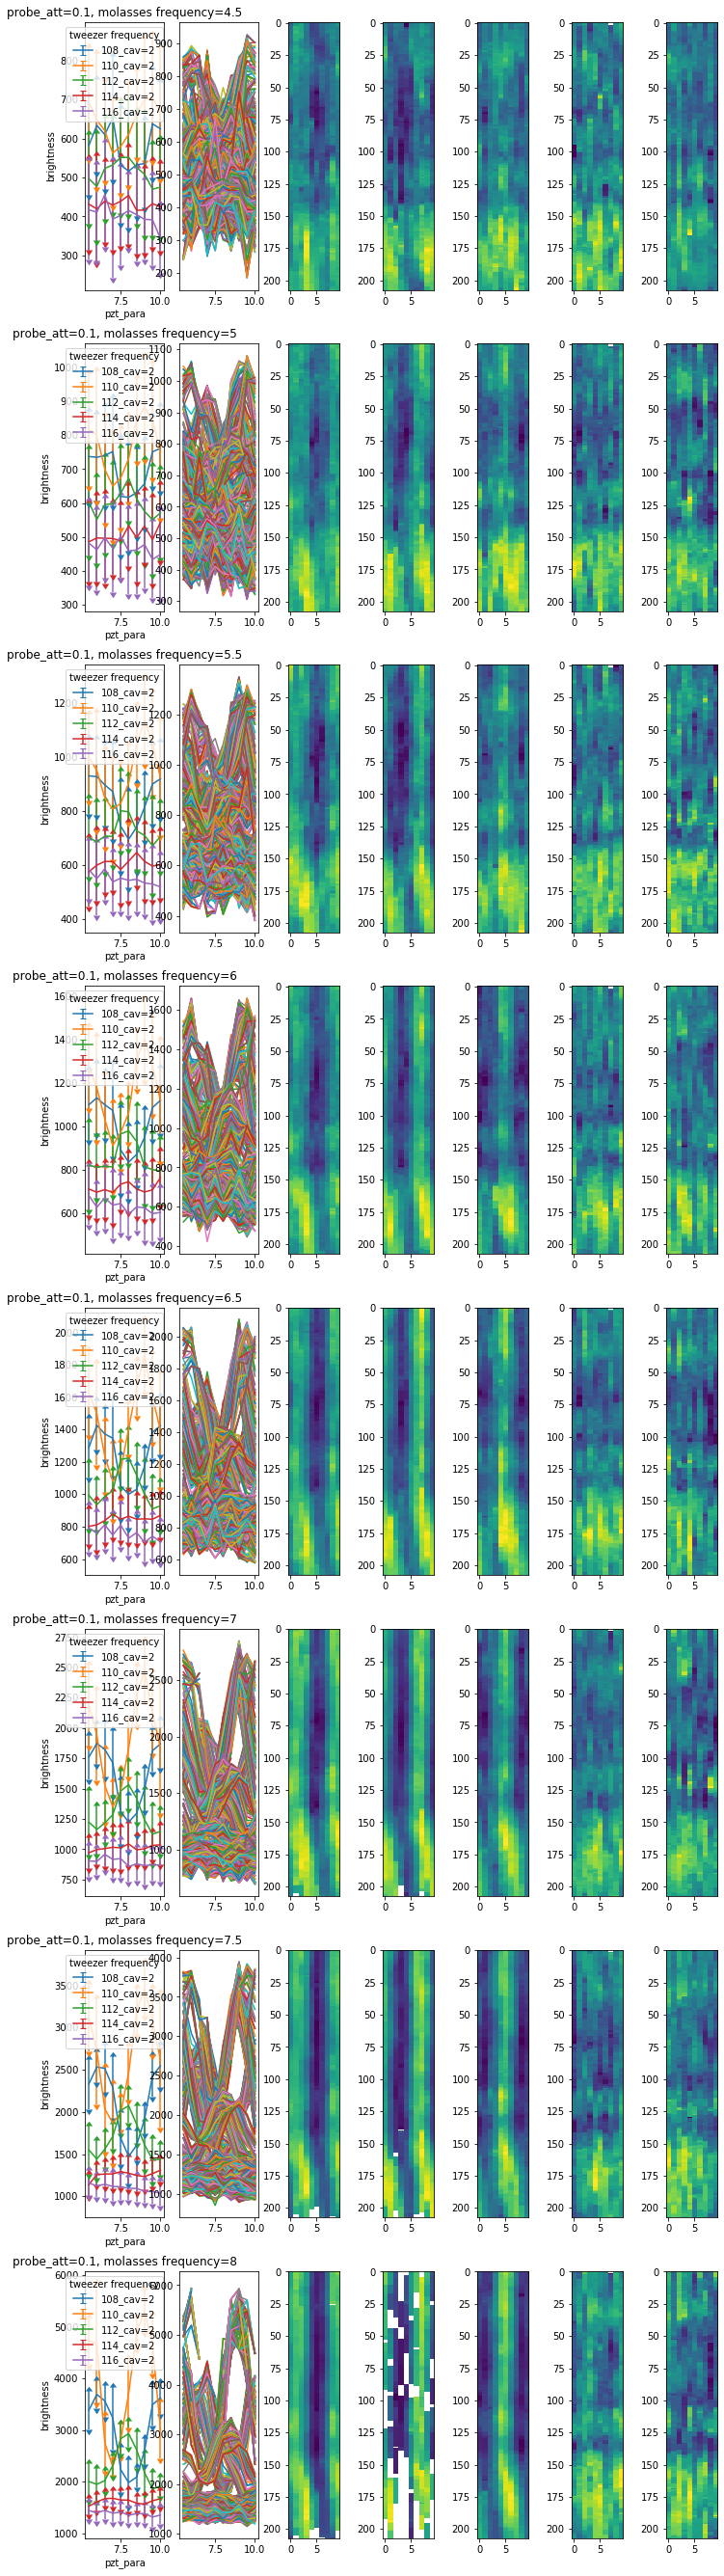

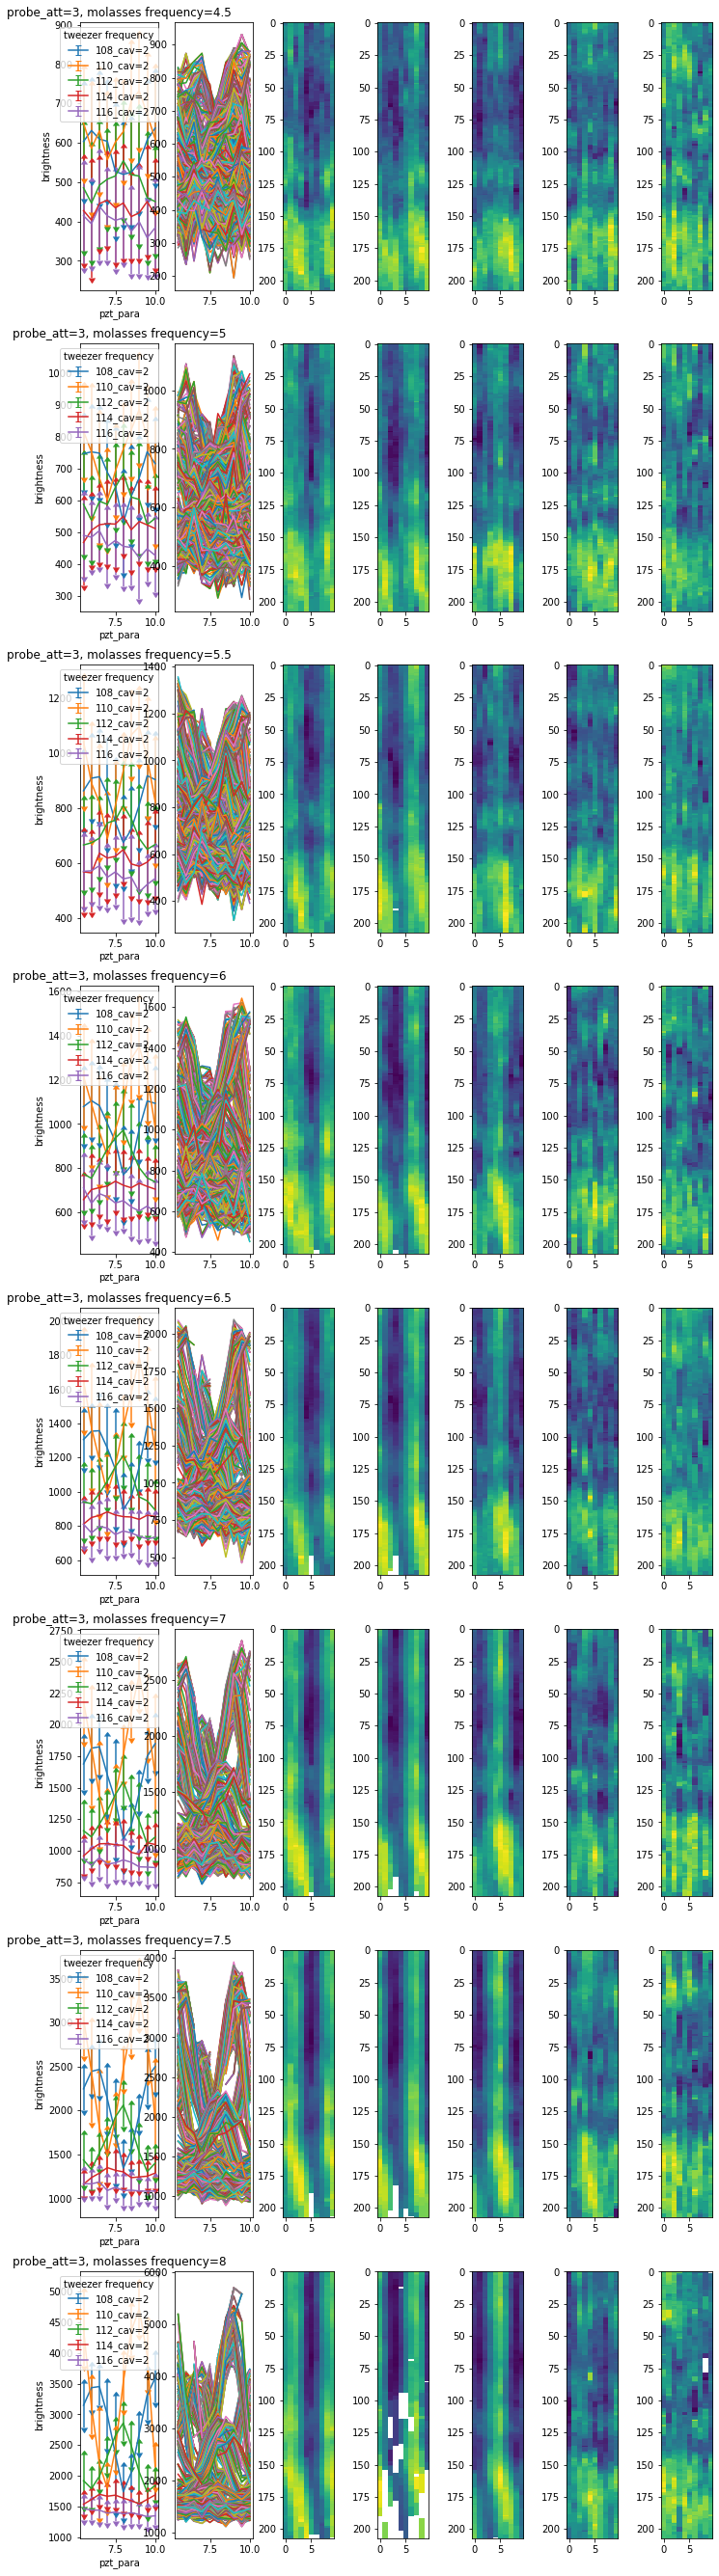

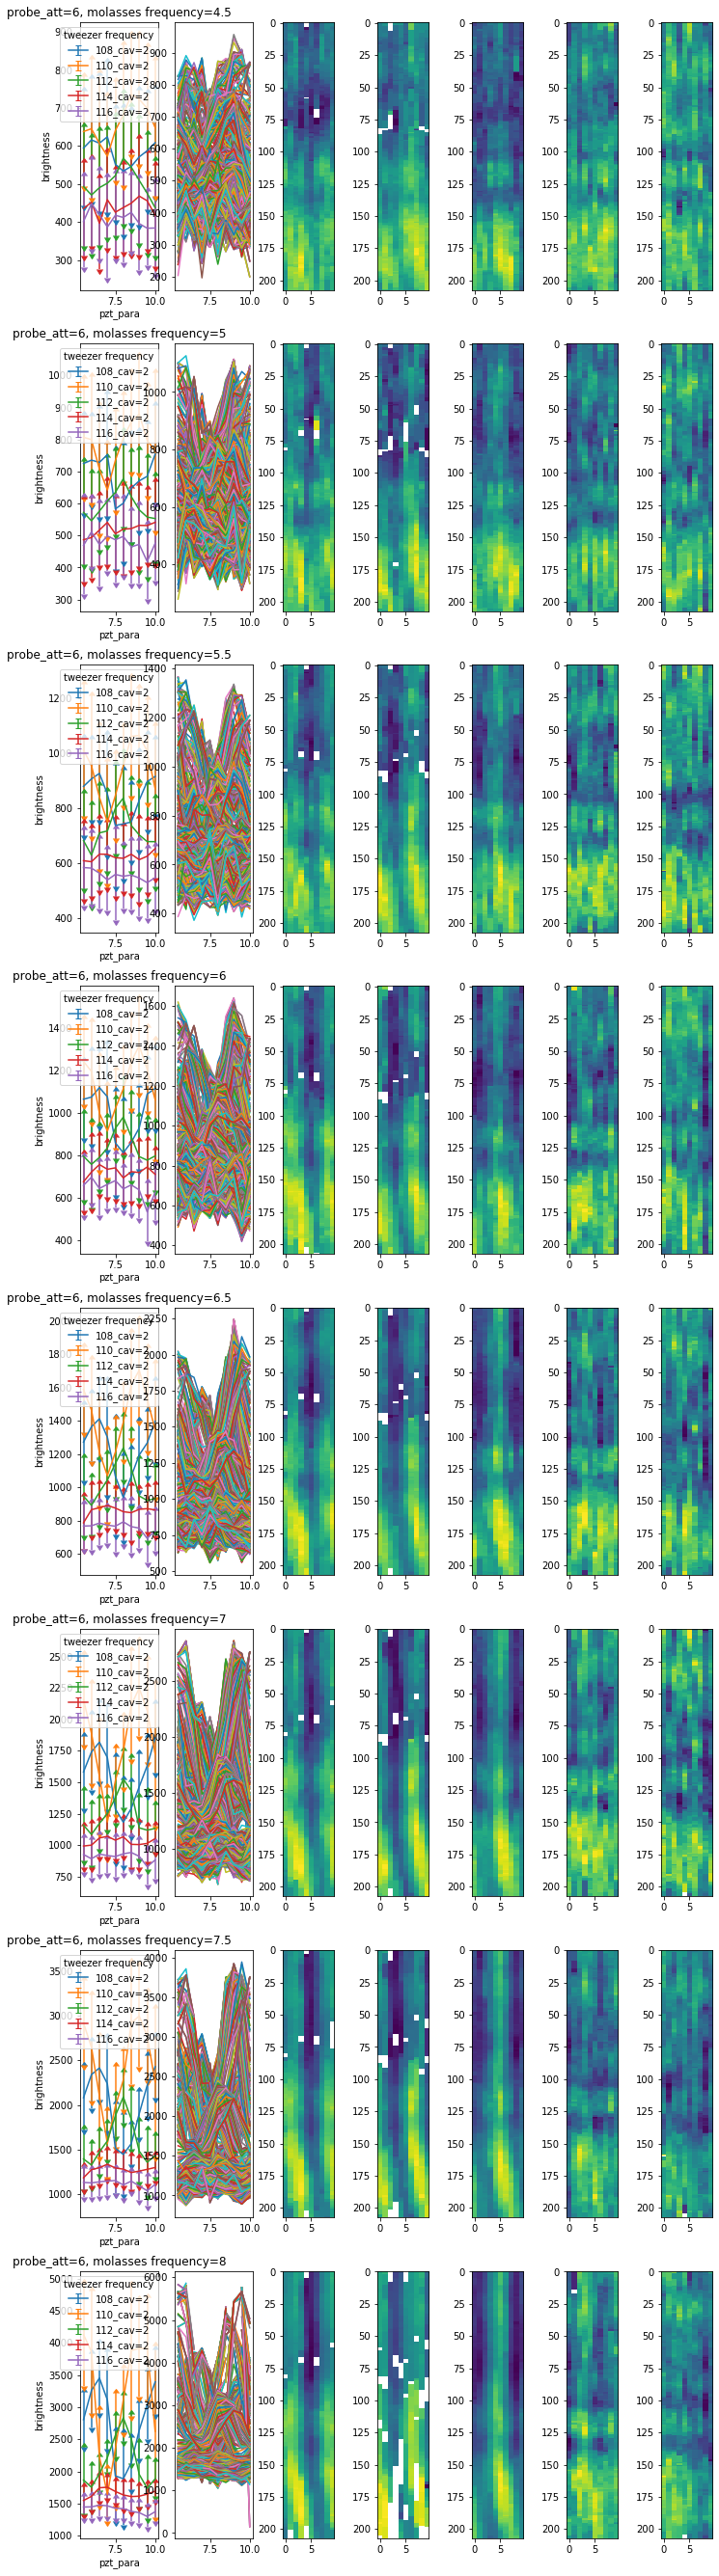

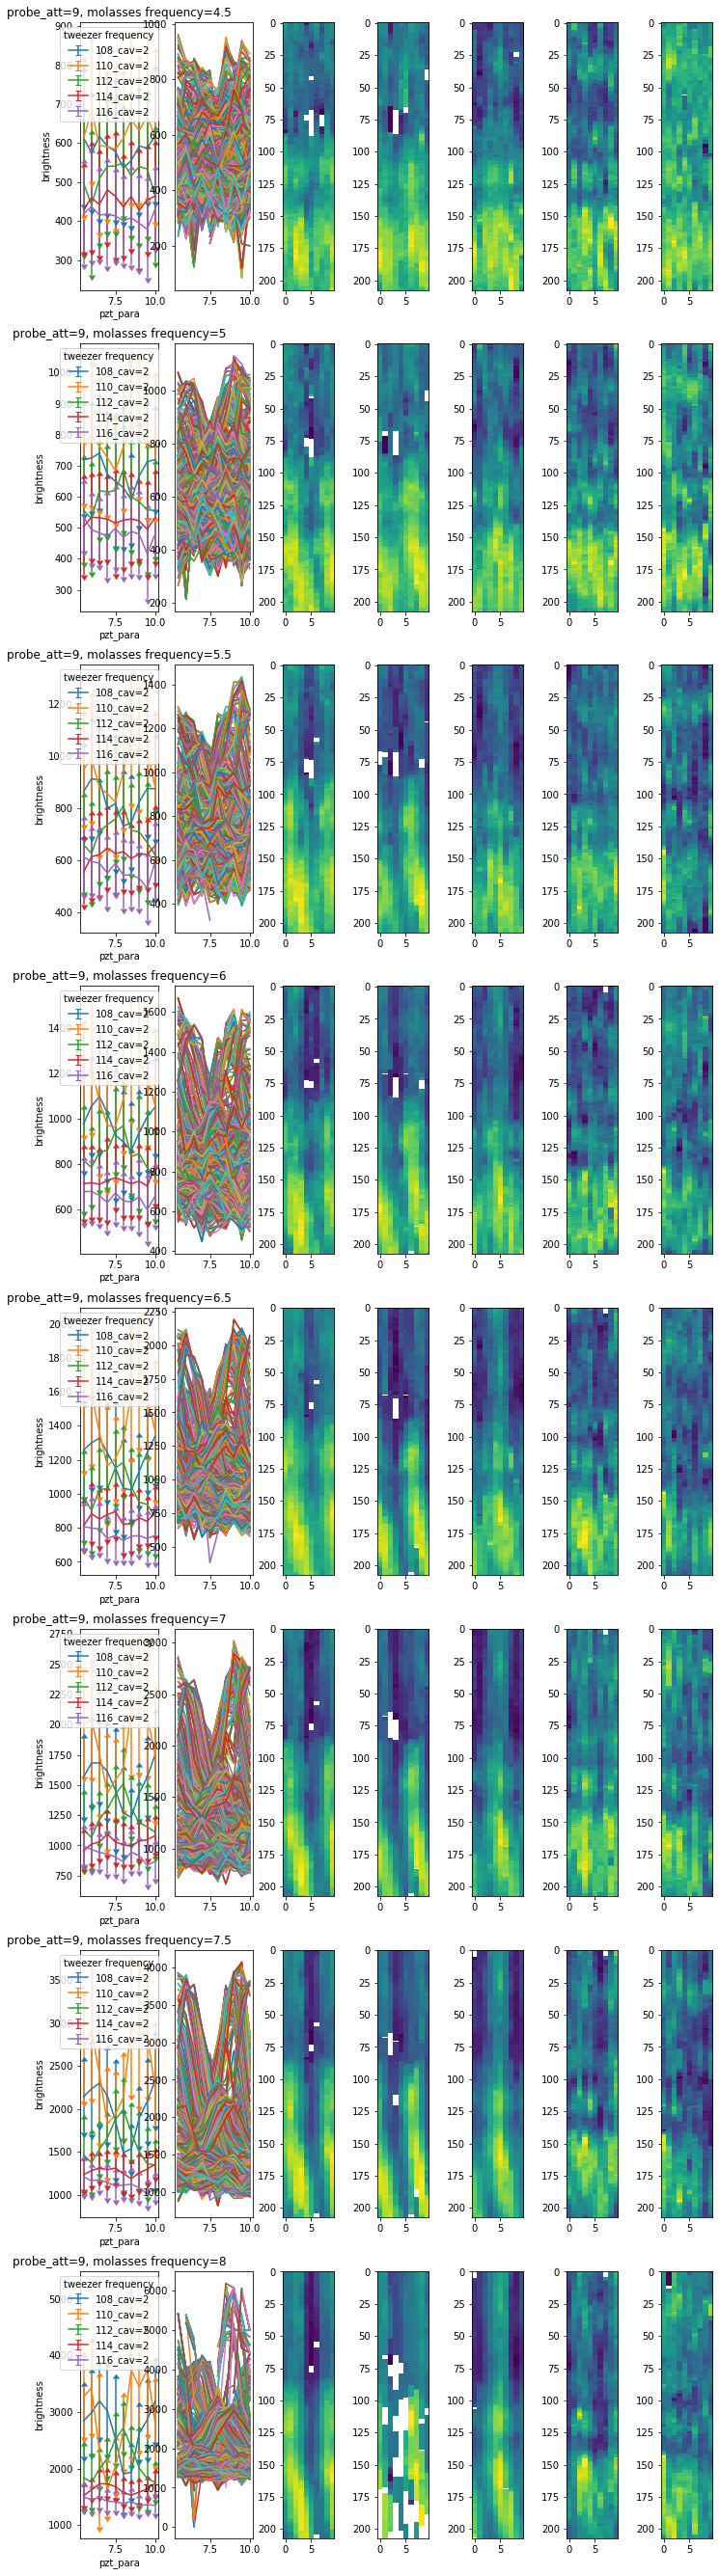

In [6]:
# PICK ONE probe_att (0.1) and molasses freq and tweezer?, plot brightness vs pzt_para
# GRID: probe_att & molasses freq (8X4=24 rows): brightness
# PLOT: brightness vs pzt_para; survival prob vs pzt_para; for all tweezers. 

# num_tweezers = 2



for probe_att_counter in range(len(probe_att_list)):
    fig, axs = plt.subplots(len(mol_freq_list), 2+num_tweezers,  figsize=(12, len(mol_freq_list)*6))
    for mol_counter in range(len(mol_freq_list)):
        axs[mol_counter,0].set_xlabel('pzt_para')
        axs[mol_counter,0].set_ylabel('brightness')
        axs[mol_counter,0].set_title(f'probe_att={probe_att_list[probe_att_counter]}, molasses frequency={mol_freq_list[mol_counter]}')        
        axs[mol_counter,0].tick_params(axis='y')
        for tweezer_counter in range(num_tweezers):
            axs[mol_counter,0].errorbar(np.array(pzt_para_list), cav_brightness_mean[mol_counter, probe_att_counter, :, tweezer_counter], \
                yerr = cav_brightness_sigma[mol_counter, probe_att_counter, :, tweezer_counter],  uplims=True, lolims=True, label= f'{tweezer_freq_list[tweezer_counter]}_cav=2')
            for loop in range(0,num_loops,1):
#                 axs[mol_counter,1].plot(np.array(pzt_para_list),np.nanmean(cav_brightness[mol_counter,probe_att_counter,:,tweezer_counter,loop:(loop+25)],1))
                axs[mol_counter,1].plot(np.array(pzt_para_list),cav_brightness_mov_avg[mol_counter,probe_att_counter,:,tweezer_counter,loop])
            axs[mol_counter,2+tweezer_counter].imshow(np.transpose(cav_brightness_mov_avg[mol_counter,probe_att_counter,:,tweezer_counter,:]), aspect = 0.25)
        axs[mol_counter,0].legend(title='tweezer frequency', bbox_to_anchor=(1.05, 1), loc='upper right')
            

In [8]:
# using outside tweezer as reference:
# averaging brightness of last tweezer over all piezo positions for each mol freq and probe att. 
outside_tweezer_counter = 4
# molasses_intensity_list = [1. ,        0.93898526, 0.9479187,  0.90025779, 0.89672007]
molasses_intensity_list = [1,1,1,1,1]

# not sure whether to avg all of these or not?
# maybe should just calc one for all? if the idea is it's outside the probe mode. 

bg_brightness_mean = np.zeros(len(mol_freq_list))
bg_brightness_sigma = np.zeros(len(mol_freq_list))
bg_brightness_mov_avg = np.zeros((len(mol_freq_list), num_loops))
bg_brightness_mov_sigma = np.zeros((len(mol_freq_list), num_loops))

cav_brightness_mov_avg_normalized = np.zeros((len(mol_freq_list),len(probe_att_list),len(pzt_para_list),len(tweezer_freq_list),num_loops))
# cav_brightness_mov_sigma_normalized = np.zeros((len(mol_freq_list),len(probe_att_list),len(pzt_para_list),len(tweezer_freq_list),num_loops))


for mol_counter in range(len(mol_freq_list)):
    for probe_att_counter in range(len(probe_att_list)):
        bg_brightness_mean[mol_counter] = np.nanmean(cav_brightness_mean[mol_counter, :, :, outside_tweezer_counter])
        bg_brightness_sigma[mol_counter] = np.sqrt(np.nanmean(cav_brightness_sigma[mol_counter, :, :, outside_tweezer_counter]**2) \
                    + np.nanmean((cav_brightness_mean[mol_counter, :, :, outside_tweezer_counter]-bg_brightness_mean[mol_counter])**2))
        for loop in range(num_loops):
            bg_brightness_mov_avg[mol_counter, loop] = np.nanmean(cav_brightness_mov_avg[mol_counter, :, :, outside_tweezer_counter,loop])
            bg_brightness_mov_sigma[mol_counter, loop] = np.sqrt(np.nanmean(cav_brightness_mov_sigma[mol_counter, :, :, outside_tweezer_counter,loop]**2) \
                    + np.nanmean((cav_brightness_mov_avg[mol_counter, :, :, outside_tweezer_counter,loop]-bg_brightness_mov_avg[mol_counter, loop])**2))
            for tweezer_counter in range(len(tweezer_freq_list)):
                cav_brightness_mov_avg_normalized[mol_counter, probe_att_counter, :, tweezer_counter, loop] = \
                cav_brightness_mov_avg[mol_counter, probe_att_counter, :, tweezer_counter, loop]/\
                        (bg_brightness_mov_avg[mol_counter, loop]/bg_brightness_mean[mol_counter])*\
                        (molasses_intensity_list[outside_tweezer_counter]/molasses_intensity_list[tweezer_counter])

bg_fidelity_mean = np.zeros(len(mol_freq_list))
bg_fidelity_sigma = np.zeros(len(mol_freq_list))
# bg_fidelity_mov_avg = np.zeros((len(mol_freq_list), len(probe_att_list), num_loops))
# bg_fidelity_mov_sigma = np.zeros((len(mol_freq_list), len(probe_att_list), num_loops))

for mol_counter in range(len(mol_freq_list)):
    for probe_att_counter in range(len(probe_att_list)):
        bg_fidelity_mean[mol_counter] = np.nanmean(cav_fidelity_mean[mol_counter, :, :, outside_tweezer_counter])
        bg_fidelity_sigma[mol_counter] = np.sqrt(np.nanmean(cav_fidelity_sigma[mol_counter, :, :, outside_tweezer_counter]**2) \
                    + np.nanmean((cav_fidelity_mean[mol_counter, :, :, outside_tweezer_counter]-bg_fidelity_mean[mol_counter])**2))
#         for loop in range(num_loops):
#             bg_fidelity_mov_avg[mol_counter, probe_att_counter,loop] = np.nanmean(cav_fidelity_mov_avg[mol_counter, probe_att_counter, :, -1,loop])
#             bg_fidelity_mov_sigma[mol_counter, probe_att_counter,loop] = np.sqrt(np.nanmean(cav_fidelity_mov_sigma[mol_counter, probe_att_counter, :, -1,loop]**2) \
#                     + np.nanmean((cav_fidelity_mov_avg[mol_counter, probe_att_counter, :, -1,loop]-bg_fidelity_mov_avg[mol_counter, probe_att_counter,loop])**2))
        

In [9]:
center_tweezer_counter = 1

loop_start = num_avg//2+1
loop_end = num_loops - num_avg//2-1

shifted_pzt_paras = np.zeros((num_frames,len(probe_att_list),len(pzt_para_list),len(tweezer_freq_list),num_loops))
shifted_pzt_para_simple = np.zeros((len(pzt_para_list),num_loops))

def func_cos(x, a, b, wavelength, xshift):
    return b + a * np.cos(4*np.pi/wavelength*(x+xshift))


y_mag = 1 #13.64
x_mag = 2/7.5


for mol_freq_counter, mol_freq in enumerate(mol_freq_list[:-2]):
    for tweezer_counter,tweezer_freq in enumerate(tweezer_freq_list[:]):
    
        for probe_att_counter, probe_att in enumerate(probe_att_list[:]):
            valid = ~(np.isnan(cav_brightness_mean[mol_freq_counter,probe_att_counter,:,tweezer_counter]) |\
                      np.isnan(cav_brightness_sigma[mol_freq_counter,probe_att_counter,:,tweezer_counter]))
            popt, pcov = curve_fit(func_cos, np.array(pzt_para_list)[valid],\
                           cav_brightness_mean[mol_freq_counter,probe_att_counter,:,tweezer_counter][valid],\
                           sigma = cav_brightness_sigma[mol_freq_counter,probe_att_counter,:,tweezer_counter][valid],\
                           p0=[1000, 4000, 7, 0], maxfev = 10000)

            a0, b0, wavelength0, xshift0 = popt
            def func_cos2(x, xshift, a):
                return b0 + a * np.cos(4*np.pi/wavelength0*(x+xshift)) 
            xshift = xshift0
            a = a0
            for loop in range(loop_start, loop_end):
                ba = cav_brightness_mov_avg_normalized[mol_freq_counter,probe_att_counter,:,tweezer_counter,loop]
                pzt_list = np.array(pzt_para_list)[~np.isnan(ba)]
                ba_sig = cav_brightness_mov_sigma[mol_freq_counter,probe_att_counter,:,tweezer_counter,loop][~np.isnan(ba)]
                ba = ba[~np.isnan(ba)]
                popt, pcov = curve_fit(func_cos2, pzt_list,\
                                       ba,\
            #                            sigma = ba_sig,\
                                       p0=[xshift, a], maxfev = 10000)

                xshift = popt[0]

                shifted_pzt_paras[mol_freq_counter,probe_att_counter,:,tweezer_counter,loop] \
                = np.array(pzt_para_list)+xshift-xshift0


                
from scipy.signal import savgol_filter
# loop_start = 10
# loop_end = 120


for mol_freq_counter, mol_freq in enumerate(mol_freq_list[:]):
    for tweezer_counter,tweezer_freq in enumerate(tweezer_freq_list[:]):
        for probe_att_counter, probe_att in enumerate(probe_att_list[:]):
            shifted_pzt_paras[mol_freq_counter,probe_att_counter,:,tweezer_counter,loop_start:loop_end] = \
             savgol_filter(np.nanmean(shifted_pzt_paras[0:5,0,:,center_tweezer_counter,loop_start:loop_end], axis = 0),\
                                   15, 3)
            
shifted_pzt_para_simple = shifted_pzt_paras[0,0,:,0,:]


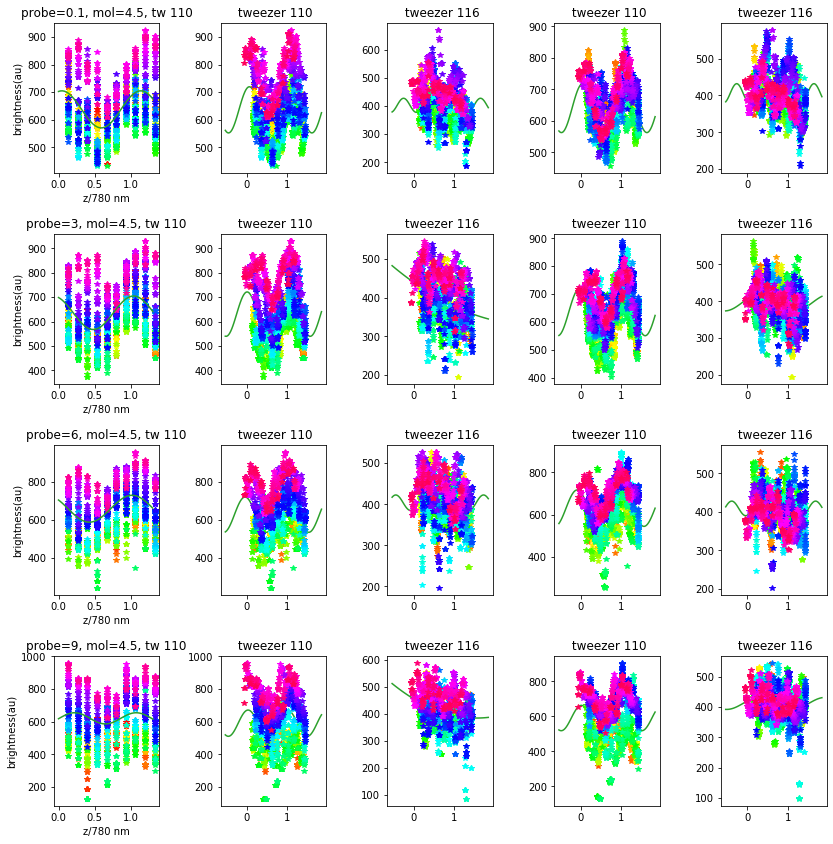

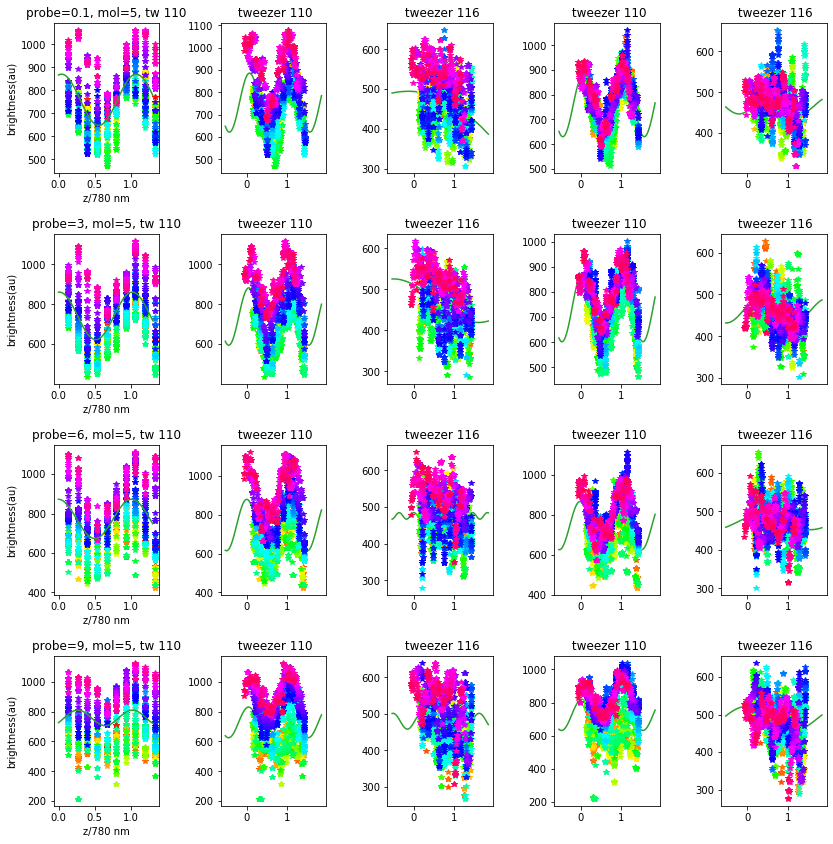

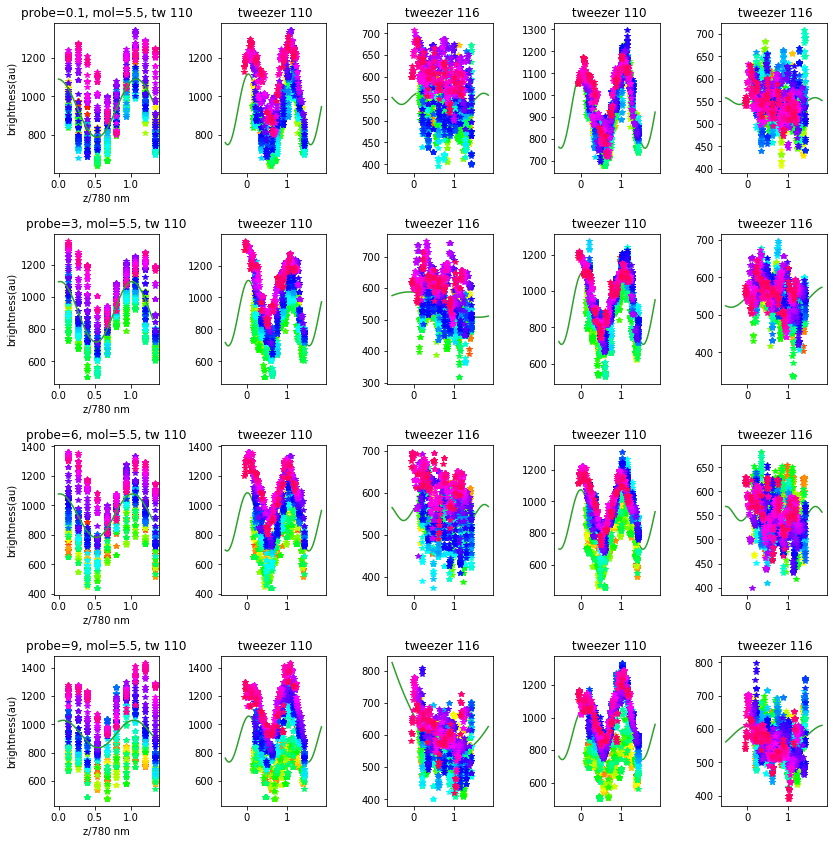

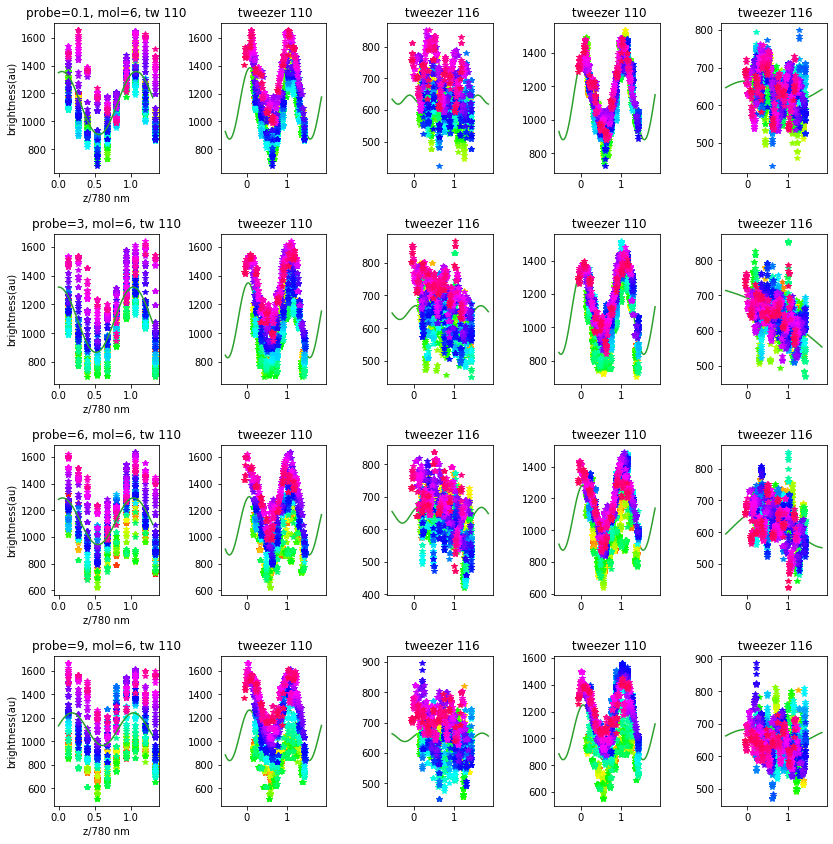

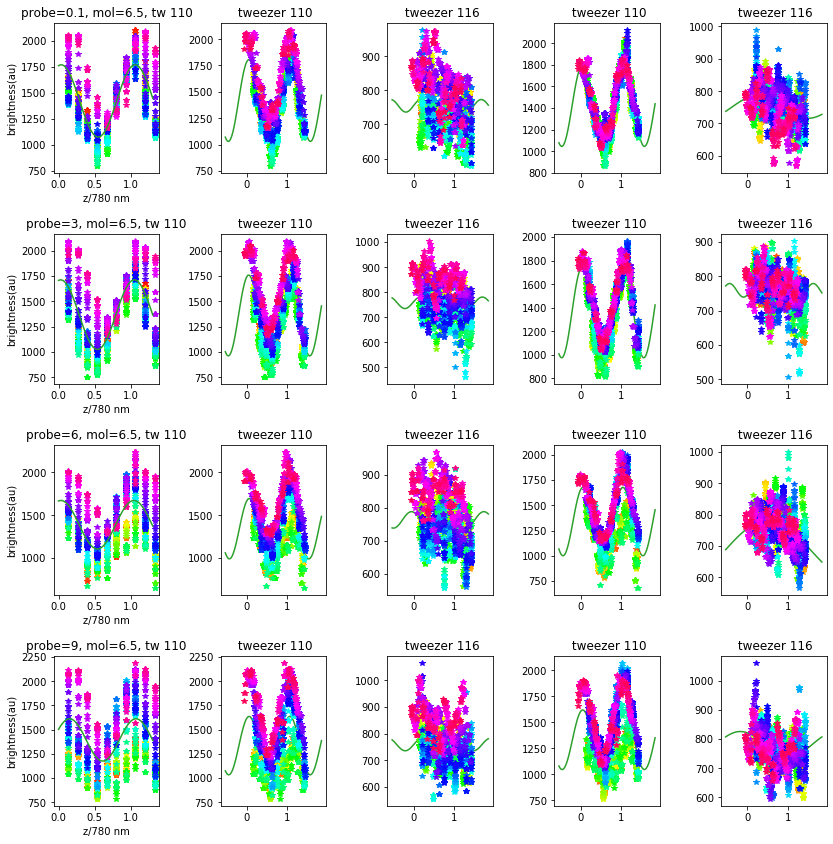

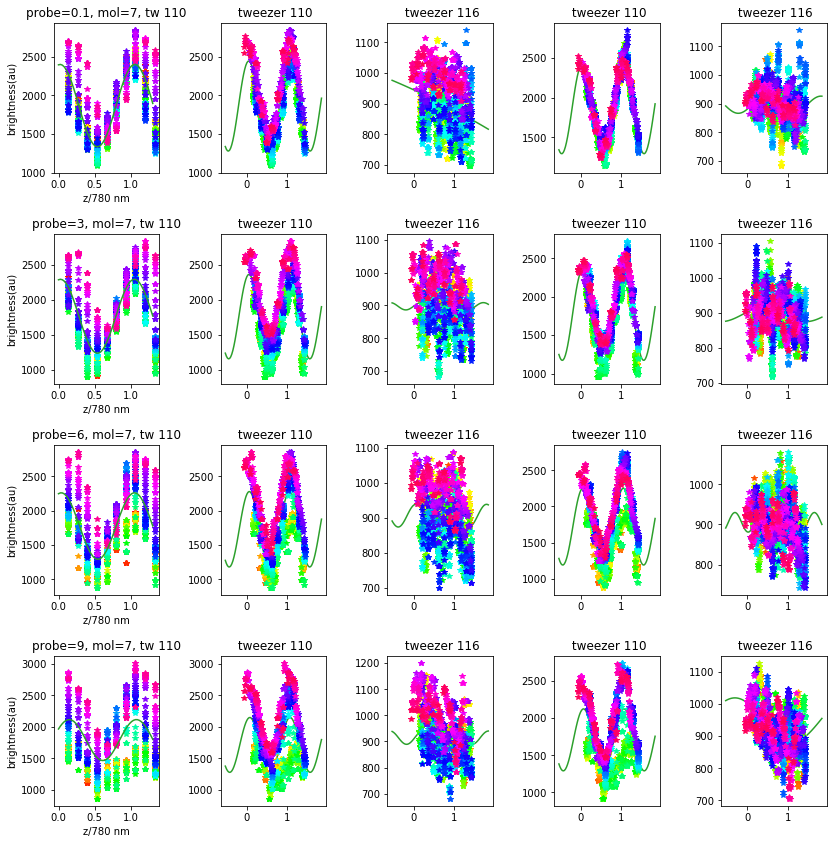

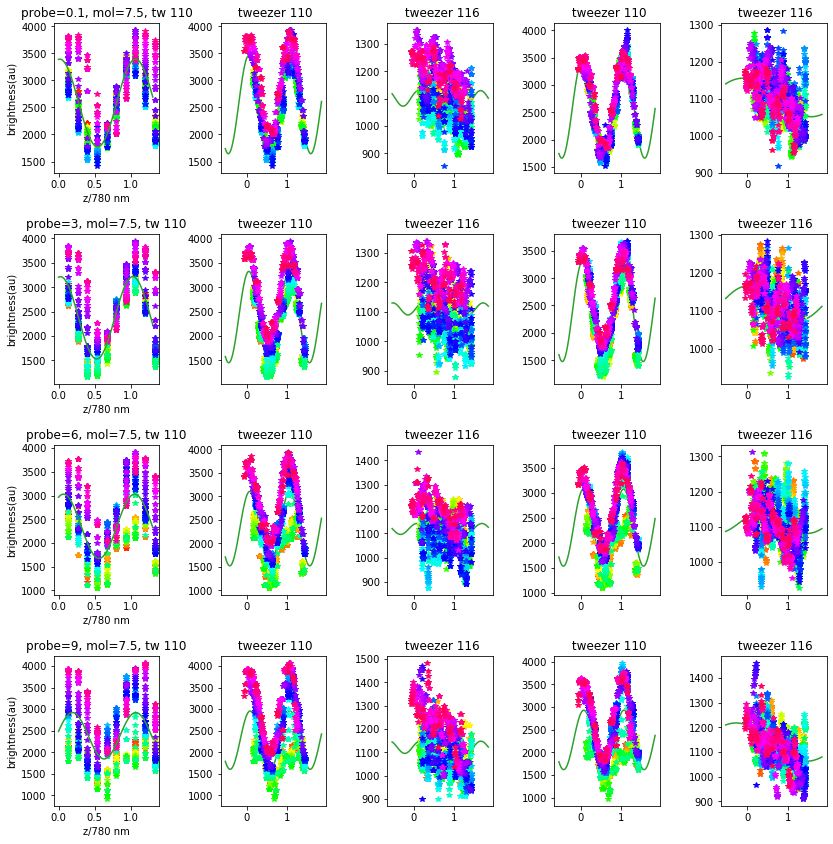

In [10]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import colorsys

def func_cos(x, a, b, wavelength, xshift):
    return b + a * np.cos(4*np.pi/wavelength*(x+xshift))
y_mag = 1 #13.64
x_mag = 2/7.5


tweezer_select = [1,4]




for mol_freq_counter, mol_freq in enumerate(mol_freq_list[:-1]):
    fig, axs = plt.subplots(len(probe_att_list), 1+2*len(tweezer_select),  figsize=(12, 3*len(probe_att_list)))
    fig.tight_layout(pad=3, w_pad=3, h_pad=4.0)
    for tweezer_counter,tweezer_freq in enumerate(tweezer_freq_list[:]):
        for probe_att_counter, probe_att in enumerate(probe_att_list[:]):
            
            valid = ~(np.isnan(cav_brightness_mean[mol_freq_counter,probe_att_counter,:,tweezer_counter]) |\
                      np.isnan(cav_brightness_sigma[mol_freq_counter,probe_att_counter,:,tweezer_counter]))
            if np.count_nonzero(valid)>4:
                popt, pcov = curve_fit(func_cos, np.array(pzt_para_list)[valid],\
                               cav_brightness_mean[mol_freq_counter,probe_att_counter,valid,tweezer_counter],\
                               sigma = cav_brightness_sigma[mol_freq_counter,probe_att_counter,valid,tweezer_counter],\
                               p0=[1000, 4000, 7, 0], maxfev = 10000)

                a0, b0, wavelength0, xshift0 = popt

            def func_cos2(x, xshift):
                return b0 + a0 * np.cos(4*np.pi/wavelength0*(x+xshift)) 
        #     print('________________________')
            for loop in range(num_loops - num_avg +1 ):
                color = colorsys.hsv_to_rgb(loop/num_loops,1,1)
                if tweezer_counter == 1: 
#                     axs[probe_att_counter,0].plot(x_mag * (xx-5),y_mag * yy,'.', color =f'C{tweezer_counter:01d}',markersize=0.5)
                    axs[probe_att_counter,0].plot(x_mag * (np.array(pzt_para_list)-5) ,\
                                                 y_mag * cav_brightness_mov_avg[mol_freq_counter,probe_att_counter,:,tweezer_counter,loop],\
                                                 '*', label= f'{tweezer_freq_list[tweezer_counter]}', color = color);


            if tweezer_counter == 1: 
                axs[probe_att_counter,0].set_xlabel('z/780 nm')
                axs[probe_att_counter,0].set_ylabel('brightness(au)')
                axs[probe_att_counter,0].set_title(f'probe={probe_att_list[probe_att_counter]}, mol={mol_freq_list[mol_freq_counter]}, tw {tweezer_freq}'\
#                f'| a0={a0:.2f}, b0={b0:.2f}'\
                );

                if np.count_nonzero(valid)>4:
                    xx = np.arange(5,10,0.1)
                    yy = func_cos(xx,a0,b0,wavelength0,xshift0)
                    axs[probe_att_counter,0].plot(x_mag * (xx-5),y_mag * yy,'-', color ='C2')
                
                
            shifted_pzt = shifted_pzt_para_simple[:, loop_start:loop_end].flatten()
            
            cav_b = cav_brightness_mov_avg[mol_freq_counter,probe_att_counter,:,tweezer_counter, loop_start:loop_end].flatten()
            cav_b_sigma = cav_brightness_mov_sigma[mol_freq_counter,probe_att_counter,:,tweezer_counter, loop_start:loop_end].flatten()


            if np.count_nonzero(~np.isnan(cav_b))>4:
                popt, pcov = curve_fit(func_cos, shifted_pzt[~np.isnan(cav_b)],\
                               cav_b[~np.isnan(cav_b)],\
            #                    sigma = cav_b_sigma[~np.isnan(cav_b)],\
                               p0=[1000, 4000, 7, 0], maxfev = 100000)

                a0, b0, wavelength0, xshift0 = popt
                xx = np.arange(3,12,0.1)
                yy = func_cos(xx,a0,b0,wavelength0,xshift0)

            
            if (tweezer_counter in tweezer_select): 
                if np.count_nonzero(~np.isnan(cav_b))>4:
                    axs[probe_att_counter, 1+tweezer_select.index(tweezer_counter)].plot(x_mag *(xx-5),y_mag*yy,'-', color ='C2')

                axs[probe_att_counter, 1+tweezer_select.index(tweezer_counter)].set_title(f' tweezer {tweezer_freq}'\
#                 f'a0={a0:.2f}, b0={b0:.2f}'\
                                                                                         );

#                 divider = make_axes_locatable(axs[probe_att_counter,1])
#                 cax = divider.append_axes('right', size='5%', pad=0.05)
#                 fig.colorbar(im, cax=cax, orientation='vertical')
                for loop in range(loop_start,loop_end):
                    color = colorsys.hsv_to_rgb(loop/num_loops,1,1)
                    axs[probe_att_counter, 1+tweezer_select.index(tweezer_counter)].plot(x_mag*(shifted_pzt_paras[mol_freq_counter,probe_att_counter,:,tweezer_counter,loop]-5),\
                                                      y_mag*cav_brightness_mov_avg[mol_freq_counter,probe_att_counter,:,tweezer_counter,loop],\
                                                      '*', color = color);



            cav_b = cav_brightness_mov_avg_normalized[mol_freq_counter,probe_att_counter,:,tweezer_counter, loop_start:loop_end].flatten()
            cav_b_sigma = cav_brightness_mov_sigma[mol_freq_counter,probe_att_counter,:,tweezer_counter, loop_start:loop_end].flatten()


            if np.count_nonzero(~np.isnan(cav_b))>4:
                popt, pcov = curve_fit(func_cos, shifted_pzt[~np.isnan(cav_b)],\
                               cav_b[~np.isnan(cav_b)],\
            #                    sigma = cav_b_sigma[~np.isnan(cav_b)],\
                               p0=[1000, 4000, 7, 0], maxfev = 100000)

                a0, b0, wavelength0, xshift0 = popt
                xx = np.arange(3,12,0.1)
                yy = func_cos(xx,a0,b0,wavelength0,xshift0)

            
            if (tweezer_counter in tweezer_select): 
                if np.count_nonzero(~np.isnan(cav_b))>4:
                    axs[probe_att_counter, 3+tweezer_select.index(tweezer_counter)].plot(x_mag *(xx-5),y_mag*yy,'-', color ='C2')

                axs[probe_att_counter, 3+tweezer_select.index(tweezer_counter)].set_title(f' tweezer {tweezer_freq}'\
#                                                                                           f', a0={a0:.2f}, b0={b0:.2f}'\
                                                                                         );

#                 divider = make_axes_locatable(axs[probe_att_counter,1])
#                 cax = divider.append_axes('right', size='5%', pad=0.05)
#                 fig.colorbar(im, cax=cax, orientation='vertical')
                for loop in range(loop_start,loop_end):
                    color = colorsys.hsv_to_rgb(loop/num_loops,1,1)
                    axs[probe_att_counter, 3+tweezer_select.index(tweezer_counter)].plot(x_mag*(shifted_pzt_paras[mol_freq_counter,probe_att_counter,:,tweezer_counter,loop]-5),\
                                                      y_mag*cav_brightness_mov_avg_normalized[mol_freq_counter,probe_att_counter,:,tweezer_counter,loop],\
                                                      '*', color = color);




In [11]:
# from scipy.signal import savgol_filter
# # tweezer_counter = 0
# for tweezer_counter in range(5):
#     fig, ax = plt.subplots(1,3,  figsize=(15, 5))
#     fig.tight_layout(pad=3, w_pad=3, h_pad=4.0)
#     for mol_freq_counter in range(len(mol_freq_list)):
#         for probe_att_counter in range(3):
#             y_data = shifted_pzt_paras[mol_freq_counter,probe_att_counter,0,tweezer_counter,num_avg//2:num_loops - num_avg//2]-np.array(pzt_para_list)[0]
#             ax[probe_att_counter].plot(y_data, label= f'mol_freq={mol_freq_list[mol_freq_counter]}',ls=':')
# #             ax[probe_att_counter].set_ylim([-1,1])
#             ax[probe_att_counter].set_title(f'cav_odt = {probe_att_list[probe_att_counter]} - tweezer freq = {tweezer_freq_list[tweezer_counter]}')
            
#             ax[probe_att_counter].set_xlabel(f'loop # (~ {(num_points*11/60):.1f} min in run)')
#             ax[probe_att_counter].set_ylabel('axial drift (780nm)')
            
#         ax[2].legend(title='mol frequency', bbox_to_anchor=(1.5, 1), loc='upper right')
        
        
        
#     for probe_att_counter in range(3):
#         y_data = np.mean(shifted_pzt_paras[1:7,probe_att_counter,0,tweezer_counter,num_avg//2:num_loops - num_avg//2], axis = 0)-np.array(pzt_para_list)[0]
#         ax[probe_att_counter].plot(y_data, label= f'mol_freq={mol_freq_list[mol_freq_counter]}',ls='-',color = 'black')
        

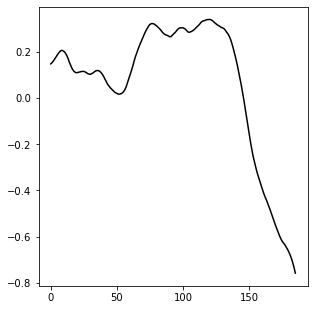

In [13]:
from scipy.signal import savgol_filter
# tweezer_counter = 0
for tweezer_counter in range(1):
    fig, ax = plt.subplots(1,1,  figsize=(5, 5))
    fig.tight_layout(pad=3, w_pad=3, h_pad=4.0)
        
    for probe_att_counter in range(1):
        y_data = np.nanmean(shifted_pzt_paras[0:4,probe_att_counter,0,tweezer_counter,loop_start:loop_end], axis = 0)-np.array(pzt_para_list)[0]
        ax.plot(y_data, label= f'mol_freq={mol_freq_list[mol_freq_counter]}',ls='-',color = 'black')
        

Now we're starting to see something!! ^^

In [14]:
# ## Alternative: calc bg_brightness and _fidelity average over all probe att settings: 

# bg_brightness = np.zeros(len(mol_freq_list))
# bg_brightness_sigma = np.zeros(len(mol_freq_list))

# for mol_counter in range(len(mol_freq_list)):
#     bg_brightness_mean[mol_counter] = np.mean(cav_brightness[mol_counter, :, :, -1])
#     bg_brightness_sigma[mol_counter] = np.sqrt(np.mean(cav_brightness_sigma[mol_counter, :, :, -1]**2) \
#                 + np.mean((cav_brightness[mol_counter, :, :, -1]-bg_brightness_mean[mol_counter])**2))
        
# bg_fidelity = np.zeros(len(mol_freq_list))
# bg_fidelity_sigma = np.zeros(len(mol_freq_list))

# for mol_counter in range(len(mol_freq_list)):
#     bg_fidelity[mol_counter] = np.mean(cav_fidelity[mol_counter, :, :, -1])
#     bg_fidelity_sigma[mol_counter] = np.sqrt(np.mean(cav_fidelity_sigma[mol_counter, :, :, -1]**2) \
#                 + np.mean((cav_fidelity[mol_counter, :, :, -1]-bg_fidelity[mol_counter])**2))

In [15]:
# # for each probe_att and molasses_freq (frame), plot brightness and survival prob vs pzt_para
# # GRID: probe_att & molasses freq (8X4=24 rows) by 2 columns: brightness and survival prob
# # PLOT: brightness vs pzt_para; survival prob vs pzt_para; for all tweezers. 

# for probe_att_counter in range(len(probe_att_list)):
#     fig, axs = plt.subplots(len(mol_freq_list), 2,  figsize=(12, len(mol_freq_list)*6))

#     for mol_counter in range(len(mol_freq_list)):
#         axs[mol_counter,0].set_xlabel('pzt_para')
#         axs[mol_counter,0].set_ylabel('brightness')
#         axs[mol_counter,1].set_xlabel('pzt_para')
#         axs[mol_counter,1].set_ylabel('survival prob')
#         axs[mol_counter,0].set_title(f'probe_att={probe_att_list[probe_att_counter]}, molasses frequency={mol_freq_list[mol_counter]}')
#     #     axs[mol_counter].errorbar(np.array(tweezer_freq_list) , all_brightness[mol_counter, 0, :] , \
#     #     yerr = all_brightness_sigma[mol_counter, 0, :],  uplims=True, lolims=True, label= 'sum')
#         for tweezer_counter in range(len(tweezer_freq_list)):
#     #         axs[mol_counter].errorbar(np.array(pzt_para_list), nocav_brightness[mol_counter, :, tweezer_counter] + 0*400 * tweezer_counter, \
# #     #         yerr = nocav_brightness_sigma[mol_counter, :, tweezer_counter],  uplims=True, lolims=True, label= f'{tweezer_freq_list[tweezer_counter]}_nocav')
# #             axs[mol_counter,0].errorbar(np.array(pzt_para_list), cav_brightness_mean[mol_counter, probe_att_counter, :, tweezer_counter] + 0*400 * tweezer_counter, \
# #             yerr = cav_brightness_sigma[mol_counter, probe_att_counter, :, tweezer_counter],  uplims=True, lolims=True, label= f'{tweezer_freq_list[tweezer_counter]}_cav=2')
# #             axs[mol_counter,1].errorbar(np.array(pzt_para_list), cav_fidelity_mean[mol_counter, probe_att_counter, :, tweezer_counter] + 0*400 * tweezer_counter, \
# #             yerr = cav_fidelity_sigma[mol_counter, probe_att_counter, :, tweezer_counter],  uplims=True, lolims=True, label= f'{tweezer_freq_list[tweezer_counter]}_cav=2')
#             axs[mol_counter,0].scatter(shifted_pzt_paras[mol_counter,probe_att_counter,:,tweezer_counter, loop_start:loop_end:10].flatten(),\
#                                        cav_brightness_mov_avg[mol_counter, probe_att_counter, :, tweezer_counter, loop_start:loop_end:10].flatten(), \
#              label= f'{tweezer_freq_list[tweezer_counter]}_cav=2')
#             axs[mol_counter,1].plot(np.array(pzt_para_list), cav_fidelity_mean[mol_counter, probe_att_counter, :, tweezer_counter] , \
#              label= f'{tweezer_freq_list[tweezer_counter]}_cav=2')
        
#         axs[mol_counter,0].errorbar(np.array(pzt_para_list), bg_brightness_mean[mol_counter, probe_att_counter] * np.ones(len(pzt_para_list)) , \
#         yerr = bg_brightness_sigma[mol_counter, probe_att_counter]* np.ones(len(pzt_para_list)),  uplims=True, lolims=True, label= f'avg of outside tweezer', color = 'black')
#         axs[mol_counter,1].errorbar(np.array(pzt_para_list), bg_fidelity_mean[mol_counter, probe_att_counter] * np.ones(len(pzt_para_list)) , \
#         yerr = bg_fidelity_sigma[mol_counter, probe_att_counter]* np.ones(len(pzt_para_list)),  uplims=True, lolims=True, label= f'avg of outside tweezer', color = 'black')
#         axs[mol_counter,1].legend(title='tweezer frequency', bbox_to_anchor=(1.05, 1), loc='upper left')
#         axs[mol_counter,0].tick_params(axis='y')
#         axs[mol_counter,1].tick_params(axis='y')

In [ ]:
# For each tweezer and each probe_att, plot brightness vs mol_freq for every pzt_position. 
# GRID: tweezer X probe_att
# PLOT: brightness X mol_freq, diff pzt settings.

plot_true = False

ac_compensation = 0.11
cropped_loop_number = loop_end-loop_start

def func(x, center, a):
    return  a / (x-center)**2

starkshift = np.zeros((len( probe_att_list), len(tweezer_freq_list),len(pzt_para_list), num_loops))
sigma_starkshift = np.zeros((len( probe_att_list), len(tweezer_freq_list),len(pzt_para_list), num_loops))


for probe_att, probe_att_counter in zip(probe_att_list[:], range(len(probe_att_list[:]))):

    for tweezer, tweezer_counter in zip(tweezer_freq_list[:], range(len(tweezer_freq_list[:]))):
        print('__________________________')
        print(f'probe = {probe_att}, tw = {tweezer}')
        if plot_true:
            fig, ax = plt.subplots(1,1,  figsize=(8, 6))
            ax.set_xlabel('mol_freq')
            ax.set_ylabel('brightness')
            ax.set_title(f'probe_att={probe_att}, tw#={tweezer_freq_list[tweezer_counter]}')    
        for loop in range(loop_start, loop_end):

            mask = bg_brightness_mov_avg[:, loop] > 400
            popt, pcov = curve_fit(func, np.array(mol_freq_list)[mask], bg_brightness_mov_avg[:, loop][mask],\
                                   sigma = bg_brightness_mov_sigma[:, loop][mask], p0=[10.5, 22000], maxfev = 10000)
            center_nocav, a_nocav = popt
            sigma_center_nocav = np.sqrt(pcov[0,0])
            sigma_a_nocav = np.sqrt(pcov[1,1])
            
            def func2(x, center):
                return  a_nocav / (x-center)**2
            
            if plot_true:
                ax.plot(np.arange(4.5,8.1,0.1),func(np.arange(4.5,8.1,0.1), a_nocav, center_nocav + ac_compensation), linestyle='-', c = 'black')
                ax.errorbar(np.array(mol_freq_list)[mask] + ac_compensation,  bg_brightness_mean[mask],\
                yerr = bg_brightness_sigma[mask],  uplims=True, lolims=True, label= f'outside_cav', linestyle='', c = 'black')
            
            for pzt_counter in range(0, len(pzt_para_list)):


                for loop in range(loop_start, loop_end):
                    colorratio = (shifted_pzt_paras[mol_counter,probe_att_counter,pzt_counter,tweezer_counter, loop]-\
                                np.min(shifted_pzt_paras[mol_counter,probe_att_counter,:,tweezer_counter, :]))/\
                                (np.max(shifted_pzt_paras[mol_counter,probe_att_counter,:,tweezer_counter, :])-\
                                np.min(shifted_pzt_paras[mol_counter,probe_att_counter,:,tweezer_counter, :]))
                    color = colorsys.hsv_to_rgb(colorratio*0.8,1,1)

                    mask = np.logical_and(np.logical_and(np.logical_and(cav_brightness_mov_avg_normalized[:, probe_att_counter, pzt_counter, tweezer_counter, loop] > 300 ,\
                        cav_brightness_mov_avg_normalized[:, probe_att_counter, pzt_counter, tweezer_counter, loop]  < 30*max(bg_brightness_mean)),\
                        cav_brightness_mov_sigma[:, probe_att_counter, pzt_counter, tweezer_counter, loop] <2000)     ,\
                        cav_brightness_mov_sigma[:, probe_att_counter, pzt_counter, tweezer_counter, loop] >0.1)       
        #             print(np.array(mol_freq_list)[mask])
        #             popt, pcov = curve_fit(func, np.array(mol_freq_list)[mask], cav_brightness[:, probe_att_counter, pzt_counter, tweezer_counter][mask],\
        #                                sigma = cav_brightness_sigma[:, probe_att_counter, pzt_counter, tweezer_counter][mask], p0=[32000, 10.5], maxfev = 10000)
                    if len(np.array(mol_freq_list)[mask]) > 1:
#                         popt, pcov = curve_fit(func2, np.array(mol_freq_list)[mask], cav_brightness_mov_avg_normalized[:, probe_att_counter, pzt_counter, tweezer_counter, loop][mask],\
#                                        sigma = cav_brightness_mov_sigma[:, probe_att_counter, pzt_counter, tweezer_counter, loop][mask], p0=[ 10.5], maxfev = 10000)
                        popt, pcov = curve_fit(func, np.array(mol_freq_list)[mask], cav_brightness_mov_avg_normalized[:, probe_att_counter, pzt_counter, tweezer_counter, loop][mask],\
                                       sigma = cav_brightness_mov_sigma[:, probe_att_counter, pzt_counter, tweezer_counter, loop][mask], p0=[10.5, 22000], maxfev = 10000)
                    else:
                        popt = [np.NaN,np.NaN]
                        pcov = np.empty((2,2))
                        pcov[:] = np.NaN
                    center_cav = popt[0]
                    a_cav = popt[1]
                    sigma_center_cav = np.sqrt(pcov[0,0])
                    starkshift_temp = center_nocav - center_cav + ac_compensation
                    sigma_starkshift_temp = np.sqrt(sigma_center_nocav**2 + sigma_center_cav**2)
                    starkshift[probe_att_counter, tweezer_counter, pzt_counter, loop] = starkshift_temp
                    sigma_starkshift[probe_att_counter, tweezer_counter, pzt_counter, loop] = sigma_starkshift_temp

                    if plot_true == True:
                        if (loop%10 == 0):
                            ax.errorbar(np.array(mol_freq_list)[mask], cav_brightness_mov_avg_normalized[:, probe_att_counter, pzt_counter, tweezer_counter,loop][mask], \
                            yerr = cav_brightness_mov_sigma[:, probe_att_counter, pzt_counter, tweezer_counter,loop][mask],  uplims=True, lolims=True, label= f'{pzt_para_list[pzt_counter]}_cav=2', linestyle='', color = color)
                            ax.plot(np.arange(4.5,8.1,0.1),func(np.arange(4.5,8.1,0.1),  center_cav, a_cav), linestyle='-', color = color, linewidth = 0.2)

            if plot_true == True:
                ax.set_ylim([0, 3*np.amax(bg_brightness_mean)])

        #         ax.legend(title='pzt para', bbox_to_anchor=(1.05, 1), loc='upper left')
                ax.tick_params(axis='y')
                plt.savefig(f'probe_att={probe_att}, tw#={tweezer_freq_list[tweezer_counter]}.png',dpi=1000)

__________________________
probe = 0.1, tw = 108


c:\python37-32\lib\site-packages\ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater
c:\python37-32\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less
c:\python37-32\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in less
c:\python37-32\lib\site-packages\ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater


__________________________
probe = 0.1, tw = 110
__________________________
probe = 0.1, tw = 112


AC Stark shift found in above fits using brightness vs mol_freq data. Do this for every loop???? 

c:\python37-32\lib\site-packages\scipy\optimize\minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
c:\python37-32\lib\site-packages\ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars


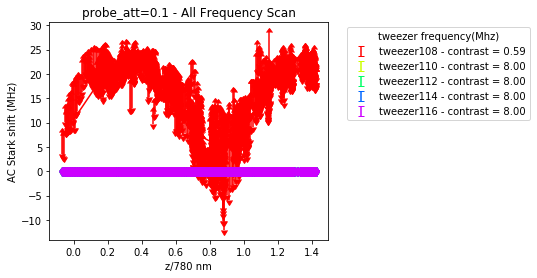

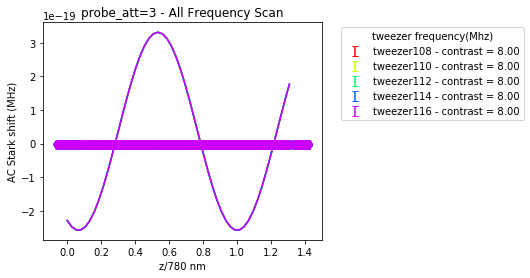

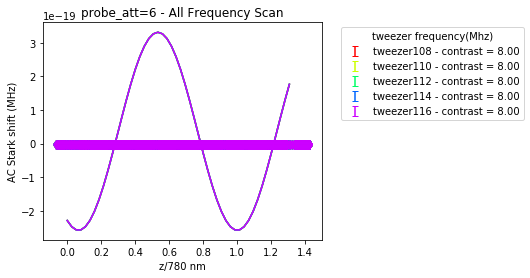

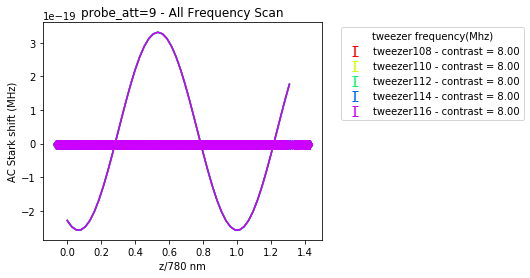

In [19]:
# AC Stark shift vs z position for diff probe_att, all tweezers
# GRID: probe_att X 1 plot
# PLOT: AC Stark shift vs z position
# all 5 tweezers per plot
# z position scaled from pzt_para to z/780nm by hand using xmag
# stark shift calculated in the cell above (using fit from freq scan!)

def func_cos(x, a, b, wavelength, phi):
    return b + a * np.cos(4*np.pi/wavelength*x + phi) 


contrast_guess = np.zeros((len(probe_att_list), len(tweezer_freq_list)))
contrast_fit =  np.zeros((len(probe_att_list), len(tweezer_freq_list)))
average_fit =  np.zeros((len(probe_att_list), len(tweezer_freq_list)))
wavelength_fit =  np.zeros((len(probe_att_list), len(tweezer_freq_list)))
sigma_contrast_fit =  np.zeros((len(probe_att_list), len(tweezer_freq_list)))
sigma_average_fit =  np.zeros((len(probe_att_list), len(tweezer_freq_list)))
sigma_wavelength_fit = np.zeros((len(probe_att_list), len(tweezer_freq_list)))
y_mag = 13.64
x_mag = 2/7.5

for probe_att, probe_att_counter in zip(probe_att_list, range(len(probe_att_list))):
    
    fig, ax = plt.subplots(1, 1,  figsize=(5, 4))
    for tweezer_counter in range(len(tweezer_freq_list)):
        mask = np.logical_and( \
                     starkshift[probe_att_counter,tweezer_counter, :, loop_start:loop_end].flatten()>-8/y_mag,
                     sigma_starkshift[probe_att_counter,tweezer_counter, :, loop_start:loop_end].flatten()<9/y_mag)
        popt, pcov = curve_fit(func_cos, shifted_pzt_paras[mol_counter,probe_att_counter,:,tweezer_counter, loop_start:loop_end].flatten()[mask], \
                               starkshift[probe_att_counter,tweezer_counter, :, loop_start:loop_end].flatten()[mask],\
#                                sigma = sigma_starkshift[probe_att_counter, tweezer_counter, :, loop_start:loop_end].flatten()[mask],\
                               p0=[1, 1, 7, 0], maxfev = 10000)
        a, b, wavelength, phi = popt
        sigma_a, sigma_b, sigma_wavelength, sigma_phi = np.sqrt(pcov.diagonal())
        contrast_fit[probe_att_counter, tweezer_counter] = np.abs(a/b)
        average_fit[probe_att_counter, tweezer_counter] = np.abs(b)
        wavelength_fit[probe_att_counter, tweezer_counter] = wavelength

        sigma_contrast_fit[probe_att_counter, tweezer_counter] = contrast_fit[probe_att_counter, tweezer_counter] * np.sqrt((sigma_a/a)**2 + (sigma_b/b)**2)
        sigma_average_fit[probe_att_counter, tweezer_counter] = sigma_b
        sigma_wavelength_fit[probe_att_counter, tweezer_counter] = sigma_wavelength

        xx = np.arange(5,10,0.1)
        yy = func_cos(xx,a,b,wavelength,phi)
        color = colorsys.hsv_to_rgb(tweezer_counter/len(tweezer_freq_list),1,1)
        ax.plot(x_mag * (xx-5),y_mag * yy,'-', color = color)
        ax.set_xlabel('z/780 nm')
        ax.set_ylabel('AC Stark shift (MHz)')
        ax.set_title(f'probe_att={probe_att} - All Frequency Scan')
    #     ax.set_title(f'tweezer nubmer={tweezer_freq_list[tweezer_counter]}')
        ax.errorbar(x_mag * (shifted_pzt_paras[mol_counter,probe_att_counter,:,tweezer_counter, loop_start:loop_end].flatten()[mask]-5),\
                                         y_mag * starkshift[probe_att_counter,tweezer_counter, :, loop_start:loop_end].flatten()[mask],\
                                             yerr = y_mag * sigma_starkshift[probe_att_counter,tweezer_counter, :, loop_start:loop_end].flatten()[mask],\
                                         uplims=True, lolims=True, label= f'tweezer{tweezer_freq_list[tweezer_counter]} - contrast = {np.abs(a/b):.2f}', ls='', color = color)
        ax.legend(title='tweezer frequency(Mhz)', bbox_to_anchor=(1.05, 1), loc='upper left')
        contrast_guess[probe_att_counter, tweezer_counter] = (np.max(starkshift[probe_att_counter, tweezer_counter, :,:])-np.min(starkshift[probe_att_counter, tweezer_counter, :,:]))/\
         (np.max(starkshift[probe_att_counter, tweezer_counter, :,:])+np.min(starkshift[probe_att_counter, tweezer_counter, :,:]))
        plt.savefig(f'Scans0 - probe_att = {probe_att}.png',dpi=1000)


MemoryError: In RendererAgg: Out of memory

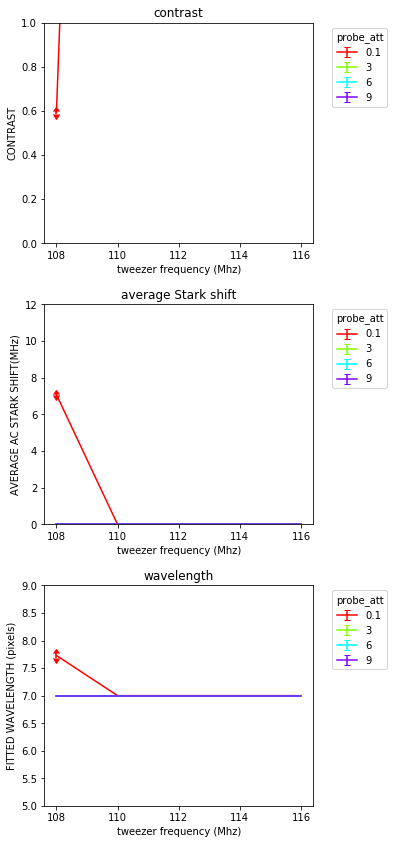

In [20]:

fig, ax = plt.subplots(3,1,  figsize=(5,12))
fig.tight_layout(pad=3, w_pad=3, h_pad=4.0)
for probe_att, probe_att_counter in zip(probe_att_list, range(len(probe_att_list))):
    color = colorsys.hsv_to_rgb(probe_att_counter/len(probe_att_list),1,1)
    ax[0].set_xlabel('tweezer frequency (Mhz)')
    ax[0].set_ylabel('CONTRAST')
    ax[0].set_ylim([0,1])
    ax[0].set_title(f'contrast')
    # ax[0].plot(tweezer_freq_list[0:10], contrast_guess[0:10],label = 'contrast_guess')
    ax[0].errorbar(tweezer_freq_list[:], contrast_fit[probe_att_counter, :], \
                                         yerr = sigma_contrast_fit[probe_att_counter, :], \
                   label = f'{probe_att}',c=color, uplims=True, lolims=True)
    # ax[0].legend(title='fit_method', bbox_to_anchor=(1.05, 1), loc='upper left')

    ax[1].set_xlabel('tweezer frequency (Mhz)')
    ax[1].set_ylabel('AVERAGE AC STARK SHIFT(MHz)')
    ax[1].set_ylim([0,12])
    ax[1].set_title(f'average Stark shift')
    ax[1].errorbar(tweezer_freq_list[:], average_fit[probe_att_counter, :]*6.69,\
                                         yerr = sigma_average_fit[probe_att_counter, :]*6.69,\
                   label = f'{probe_att}',c=color, uplims=True, lolims=True)
    # ax[1].legend(title='fit_method', bbox_to_anchor=(1.05, 1), loc='upper left')


    ax[2].set_xlabel('tweezer frequency (Mhz)')
    ax[2].set_ylabel('FITTED WAVELENGTH (pixels)')
    ax[2].set_ylim([5,9])
    ax[2].set_title(f'wavelength')
    ax[2].errorbar(tweezer_freq_list[:], wavelength_fit[probe_att_counter, :],\
                                         yerr = sigma_wavelength_fit[probe_att_counter, :],\
                   label = f'{probe_att}',c=color, uplims=True, lolims=True)
ax[0].legend(title='probe_att', bbox_to_anchor=(1.05, 1), loc='upper left')
ax[1].legend(title='probe_att', bbox_to_anchor=(1.05, 1), loc='upper left')
ax[2].legend(title='probe_att', bbox_to_anchor=(1.05, 1), loc='upper left')
fig.savefig('Tweezers0.png',dpi=1000)

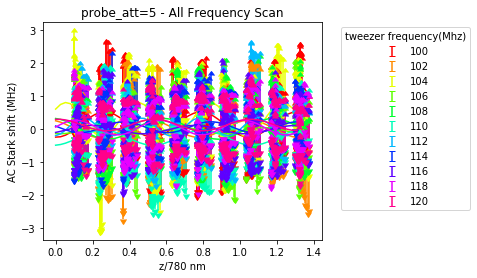

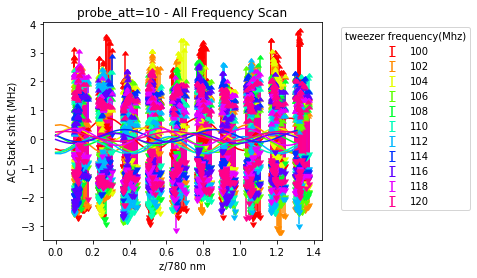

In [18]:
# AC Stark shift vs z position for diff probe_att, all tweezers
# GRID: probe_att X 1 plot
# PLOT: AC Stark shift vs z position
# all 5 tweezers per plot
# z position scaled from pzt_para to z/780nm by hand using xmag
# stark shift calculated in the cell above (using fit from freq scan!)

def func_cos(x, a, b, wavelength, phi):
    return b + a * np.cos(4*np.pi/wavelength*x + phi) 


contrast_guess = np.zeros((len(probe_att_list), len(tweezer_freq_list)))
contrast_fit =  np.zeros((len(probe_att_list), len(tweezer_freq_list)))
average_fit =  np.zeros((len(probe_att_list), len(tweezer_freq_list)))
wavelength_fit =  np.zeros((len(probe_att_list), len(tweezer_freq_list)))
sigma_contrast_fit =  np.zeros((len(probe_att_list), len(tweezer_freq_list)))
sigma_average_fit =  np.zeros((len(probe_att_list), len(tweezer_freq_list)))
sigma_wavelength_fit = np.zeros((len(probe_att_list), len(tweezer_freq_list)))
y_mag = 13.64
x_mag = 2/7.5

for probe_att, probe_att_counter in zip(probe_att_list[1:], range(1,len(probe_att_list))):
    
    fig, ax = plt.subplots(1, 1,  figsize=(5, 4))
    for tweezer_counter in range(len(tweezer_freq_list)):
   
        mask = ~(np.isnan(starkshift[probe_att_counter,tweezer_counter, :, loop_start:loop_end].flatten())|\
                 np.isnan(starkshift[0,tweezer_counter, :, loop_start:loop_end].flatten()))
        popt, pcov = curve_fit(func_cos, shifted_pzt_paras[mol_counter,probe_att_counter,:,tweezer_counter, loop_start:loop_end].flatten()[mask], \
                               starkshift[probe_att_counter,tweezer_counter, :, loop_start:loop_end].flatten()[mask] - \
                               starkshift[0,tweezer_counter, :, loop_start:loop_end].flatten()[mask],\
#                                sigma = sigma_starkshift[probe_att_counter, tweezer_counter, :, loop_start:loop_end].flatten()[mask],\
                               p0=[1, 1, 3.5, 0], maxfev = 10000)
        a, b, wavelength, phi = popt
        sigma_a, sigma_b, sigma_wavelength, sigma_phi = np.sqrt(pcov.diagonal())
        contrast_fit[probe_att_counter, tweezer_counter] = np.abs(a/b)
        average_fit[probe_att_counter, tweezer_counter] = np.abs(b)
        wavelength_fit[probe_att_counter, tweezer_counter] = wavelength

        sigma_contrast_fit[probe_att_counter, tweezer_counter] = contrast_fit[probe_att_counter, tweezer_counter] * np.sqrt((sigma_a/a)**2 + (sigma_b/b)**2)
        sigma_average_fit[probe_att_counter, tweezer_counter] = sigma_b
        sigma_wavelength_fit[probe_att_counter, tweezer_counter] = sigma_wavelength

        xx = np.arange(5,10,0.1)
        yy = func_cos(xx,a,b,wavelength,phi)
        color = colorsys.hsv_to_rgb(tweezer_counter/len(tweezer_freq_list),1,1)
        ax.plot(x_mag * (xx-5),y_mag * yy,'-', color = color)
        ax.set_xlabel('z/780 nm')
        ax.set_ylabel('AC Stark shift (MHz)')
        ax.set_title(f'probe_att={probe_att} - All Frequency Scan')
    #     ax.set_title(f'tweezer nubmer={tweezer_freq_list[tweezer_counter]}')
    
        sigma_temp_0 = sigma_starkshift[0,tweezer_counter, :, loop_start:loop_end].flatten()[mask]
        sigma_temp_1 = sigma_starkshift[probe_att_counter,tweezer_counter, :, loop_start:loop_end].flatten()[mask]
        
        ax.errorbar(x_mag * (shifted_pzt_paras[mol_counter,probe_att_counter,:,tweezer_counter, loop_start:loop_end].flatten()[mask]-5),\
                                         y_mag * (starkshift[probe_att_counter,tweezer_counter, :, loop_start:loop_end].flatten()[mask] - \
                                                  starkshift[0,tweezer_counter, :, loop_start:loop_end].flatten()[mask]),\
                                             yerr = y_mag * (sigma_temp_1**2 + sigma_temp_0**2)**0.5 ,\
                                         uplims=True, lolims=True, label= f'{tweezer_freq_list[tweezer_counter]}', ls='', color = color)
        ax.legend(title='tweezer frequency(Mhz)', bbox_to_anchor=(1.05, 1), loc='upper left')
        contrast_guess[probe_att_counter, tweezer_counter] = (np.max(starkshift[probe_att_counter, tweezer_counter, :,:])-np.min(starkshift[probe_att_counter, tweezer_counter, :,:]))/\
         (np.max(starkshift[probe_att_counter, tweezer_counter, :,:])+np.min(starkshift[probe_att_counter, tweezer_counter, :,:]))
        plt.savefig(f'ScanProbeOnly - probe_att = {probe_att}.png',dpi=1000)


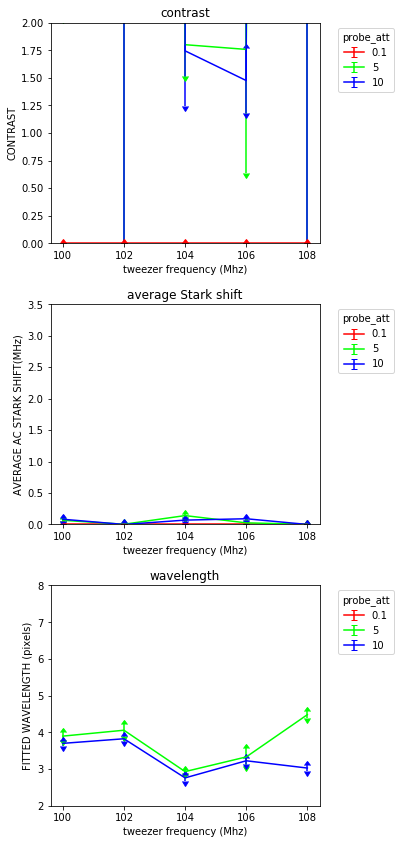

In [19]:

fig, ax = plt.subplots(3,1,  figsize=(5,12))
fig.tight_layout(pad=3, w_pad=3, h_pad=4.0)
for probe_att, probe_att_counter in zip(probe_att_list, range(len(probe_att_list))):
    color = colorsys.hsv_to_rgb(probe_att_counter/len(probe_att_list),1,1)
    ax[0].set_xlabel('tweezer frequency (Mhz)')
    ax[0].set_ylabel('CONTRAST')
    ax[0].set_ylim([0,2])
    ax[0].set_title(f'contrast')
    # ax[0].plot(tweezer_freq_list[0:10], contrast_guess[0:10],label = 'contrast_guess')
    ax[0].errorbar(tweezer_freq_list[0:5], contrast_fit[probe_att_counter, 0:5], \
                                         yerr = sigma_contrast_fit[probe_att_counter, 0:5], \
                   label = f'{probe_att}',c=color, uplims=True, lolims=True)
    # ax[0].legend(title='fit_method', bbox_to_anchor=(1.05, 1), loc='upper left')

    ax[1].set_xlabel('tweezer frequency (Mhz)')
    ax[1].set_ylabel('AVERAGE AC STARK SHIFT(MHz)')
    ax[1].set_ylim([0,3.5])
    ax[1].set_title(f'average Stark shift')
    ax[1].errorbar(tweezer_freq_list[0:5], average_fit[probe_att_counter, 0:5]*6.69,\
                                         yerr = sigma_average_fit[probe_att_counter, 0:5]*6.69,\
                   label = f'{probe_att}',c=color, uplims=True, lolims=True)
    # ax[1].legend(title='fit_method', bbox_to_anchor=(1.05, 1), loc='upper left')


    ax[2].set_xlabel('tweezer frequency (Mhz)')
    ax[2].set_ylabel('FITTED WAVELENGTH (pixels)')
    ax[2].set_ylim([2,8])
    ax[2].set_title(f'wavelength')
    ax[2].errorbar(tweezer_freq_list[0:5], wavelength_fit[probe_att_counter, 0:5],\
                                         yerr = sigma_wavelength_fit[probe_att_counter, 0:5],\
                   label = f'{probe_att}',c=color, uplims=True, lolims=True)
ax[0].legend(title='probe_att', bbox_to_anchor=(1.05, 1), loc='upper left')
ax[1].legend(title='probe_att', bbox_to_anchor=(1.05, 1), loc='upper left')
ax[2].legend(title='probe_att', bbox_to_anchor=(1.05, 1), loc='upper left')
fig.savefig('Probe_Tweezers0.png',dpi=1000)

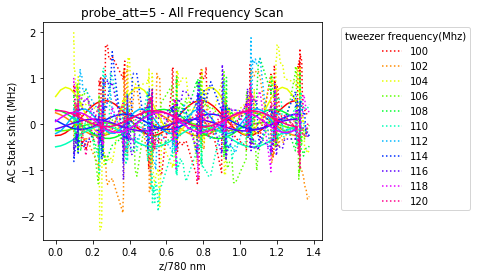

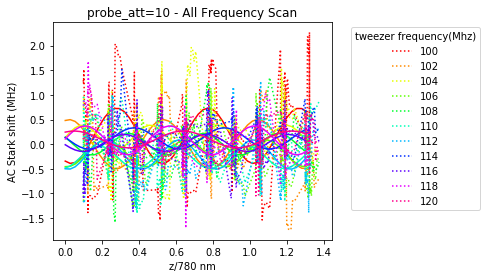

In [20]:
# AC Stark shift vs z position for diff probe_att, all tweezers
# GRID: probe_att X 1 plot
# PLOT: AC Stark shift vs z position
# all 5 tweezers per plot
# z position scaled from pzt_para to z/780nm by hand using xmag
# stark shift calculated in the cell above (using fit from freq scan!)

def func_cos(x, a, b, wavelength, phi):
    return b + a * np.cos(4*np.pi/wavelength*x + phi) 


contrast_guess = np.zeros((len(probe_att_list), len(tweezer_freq_list)))
contrast_fit =  np.zeros((len(probe_att_list), len(tweezer_freq_list)))
average_fit =  np.zeros((len(probe_att_list), len(tweezer_freq_list)))
wavelength_fit =  np.zeros((len(probe_att_list), len(tweezer_freq_list)))
sigma_contrast_fit =  np.zeros((len(probe_att_list), len(tweezer_freq_list)))
sigma_average_fit =  np.zeros((len(probe_att_list), len(tweezer_freq_list)))
sigma_wavelength_fit = np.zeros((len(probe_att_list), len(tweezer_freq_list)))
y_mag = 13.64
x_mag = 2/7.5

for probe_att, probe_att_counter in zip(probe_att_list[1:], range(1,len(probe_att_list))):
    
    fig, ax = plt.subplots(1, 1,  figsize=(5, 4))
    for tweezer_counter in range(len(tweezer_freq_list)):
   
        mask = ~(np.isnan(starkshift[probe_att_counter,tweezer_counter, :, loop_start:loop_end].flatten())|\
                 np.isnan(starkshift[0,tweezer_counter, :, loop_start:loop_end].flatten()))
        popt, pcov = curve_fit(func_cos, shifted_pzt_paras[mol_counter,probe_att_counter,:,tweezer_counter, loop_start:loop_end].flatten()[mask], \
                               starkshift[probe_att_counter,tweezer_counter, :, loop_start:loop_end].flatten()[mask] - \
                               starkshift[0,tweezer_counter, :, loop_start:loop_end].flatten()[mask],\
#                                sigma = sigma_starkshift[probe_att_counter, tweezer_counter, :, loop_start:loop_end].flatten()[mask],\
                               p0=[1, 1, 3.5, 0], maxfev = 10000)
        a, b, wavelength, phi = popt
        sigma_a, sigma_b, sigma_wavelength, sigma_phi = np.sqrt(pcov.diagonal())
        contrast_fit[probe_att_counter, tweezer_counter] = np.abs(a/b)
        average_fit[probe_att_counter, tweezer_counter] = np.abs(b)
        wavelength_fit[probe_att_counter, tweezer_counter] = wavelength

        sigma_contrast_fit[probe_att_counter, tweezer_counter] = contrast_fit[probe_att_counter, tweezer_counter] * np.sqrt((sigma_a/a)**2 + (sigma_b/b)**2)
        sigma_average_fit[probe_att_counter, tweezer_counter] = sigma_b
        sigma_wavelength_fit[probe_att_counter, tweezer_counter] = sigma_wavelength

        xx = np.arange(5,10,0.1)
        yy = func_cos(xx,a,b,wavelength,phi)
        color = colorsys.hsv_to_rgb(tweezer_counter/len(tweezer_freq_list),1,1)
        ax.plot(x_mag * (xx-5),y_mag * yy,'-', color = color)
        ax.set_xlabel('z/780 nm')
        ax.set_ylabel('AC Stark shift (MHz)')
        ax.set_title(f'probe_att={probe_att} - All Frequency Scan')
    #     ax.set_title(f'tweezer nubmer={tweezer_freq_list[tweezer_counter]}')
    
        sigma_temp_0 = sigma_starkshift[0,tweezer_counter, :, loop_start:loop_end].flatten()[mask]
        sigma_temp_1 = sigma_starkshift[probe_att_counter,tweezer_counter, :, loop_start:loop_end].flatten()[mask]
        
        ax.plot(x_mag * (shifted_pzt_paras[mol_counter,probe_att_counter,:,tweezer_counter, loop_start:loop_end].flatten()[mask]-5),\
                                         y_mag * (starkshift[probe_att_counter,tweezer_counter, :, loop_start:loop_end].flatten()[mask] - \
                                                  starkshift[0,tweezer_counter, :, loop_start:loop_end].flatten()[mask]),\
#                                              yerr = y_mag * (sigma_temp_1**2 + sigma_temp_0**2)**0.5 ,uplims=True, lolims=True,\
                                          label= f'{tweezer_freq_list[tweezer_counter]}', ls=':', color = color)
        ax.legend(title='tweezer frequency(Mhz)', bbox_to_anchor=(1.05, 1), loc='upper left')
        contrast_guess[probe_att_counter, tweezer_counter] = (np.max(starkshift[probe_att_counter, tweezer_counter, :,:])-np.min(starkshift[probe_att_counter, tweezer_counter, :,:]))/\
         (np.max(starkshift[probe_att_counter, tweezer_counter, :,:])+np.min(starkshift[probe_att_counter, tweezer_counter, :,:]))
        plt.savefig(f'ScanProbeOnly - probe_att = {probe_att}.png',dpi=1000)
